indiquer sur quel souris on souhaite faire l'analyse

In [9]:
#initialise le code et donne les sessionssur cette souris en memoire
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.patches import Polygon
from math import isclose
from scipy.ndimage import gaussian_filter as smooth
from own_Functions import *
from median_thomas import *

#videoFolder_path='/home/david/Documents/'
videoFolder_path = "/localdata/alicedata/"
#videoFolder_path='/Users/davidrobbe/MEGAsync/Python/CorticoStriatalProject/Videos/' #à faire: un code qui détecte si on est sur windows ou linux et qui décide du path à prendre dans ce cas 
mouseName='MOU4087'
mouseFolder_Path=videoFolder_path+mouseName
#print(mouseFolder_Path)
os.chdir(mouseFolder_Path)
sessionFolders=[name for name in os.listdir(mouseFolder_Path) if os.path.isdir(os.path.join(mouseFolder_Path, name)) ]
sessionFolders.sort()
print(sessionFolders)


TRAPEZE_SIZE = 35
Resolution = 512,512 # variable which store the size of the experimental field in pixel

#--------------------------------------------------
# position patches & trapezes & water ports
#--------------------------------------------------
#definition from Video_processimgPLT_lastDav02.py
#The patch coodinates in 512*512 pixel resolution. Real values 2048*2048 pixels images value after 4x bigger
#DavQ: not clear I though patches were the entire space divided in 4. Where is 0,0 .....
#invert the y positions
# NWpatch_coords = [[104, Resolution[1] -  125], [173, Resolution[1] -  125], [173, Resolution[1] -  201], [104, Resolution[1] -  201]]
NWpatch_coords = [[109, Resolution[1] -  130], [188, Resolution[1] -  130], [188, Resolution[1] -  215], [109, Resolution[1] -  215]]
# NEpatch_coords = [[330, Resolution[1] -  120], [400, Resolution[1] -  120], [400, Resolution[1] -  200], [330, Resolution[1] -  200]]
NEpatch_coords = [[320, Resolution[1] -  130], [400, Resolution[1] -  130], [400, Resolution[1] -  210], [320, Resolution[1] -  210]]
# SWpatch_coords = [[109, Resolution[1] -  351], [181, Resolution[1] -  351], [181, Resolution[1] -  410], [109, Resolution[1] -  410]]
SWpatch_coords = [[112, Resolution[1] -  344], [191, Resolution[1] -  344], [191, Resolution[1] -  410], [112, Resolution[1] -  410]]
#SEpatch_coords = [[330, Resolution[1] -  350], [400, Resolution[1] -  350], [400, Resolution[1] -  410], [330, Resolution[1] -  410]]
SEpatch_coords = [[315, Resolution[1] -  350], [395, Resolution[1] -  350], [395, Resolution[1] -  415], [315, Resolution[1] -  415]]

waterports = {0:(170,88), 1:(228, 150), 2:(178, 200), 3:(115, 155),#define the coordinate of the waterport
                    4:(380, 93), 5:(430, 155), 6:(388, 203), 7:(335, 155),
                    8:(170, 305), 9:(228, 355), 10:(175, 415), 11:(115, 357),
                    12:(385, 300), 13:(430, 352), 14:(385, 413), 15:(335, 365)}


# if we want to focus on a small part of the trajectory, format is : [[time beginning epoch 1, time end epoch 1], [time beginning epoch 2, ...]
#the epoch must have NO INTERSCT and be listed in RISING number
time_analysis = [[350, 400], [400, 450]] #current analysis correspond to 1.21 to 1.37 and 9.49 to 10.04 on the video
time_analysis.insert(0, [0, 0])

try_sigma_value =  [0.5, 1, 1.5, 2, 2.5, 3] #value of sigma to be tried on for the Gaussian filter used to smooth the values
true_sigma = 1 # the sigma used for the remaining of the analysis


MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, fusionne the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
#the cut speed is the value under which the animal is considerd to not be mouving and as such, cut from the analysis of 
try_cut_speed = [ 7] #value to try and show the results of 
true_cut_speed = 7 #value to be used for the remaining of the analysis

try_ecart_angle = [ 1, 2, 3]
true_ecart_angle = 1 # if a change is made, must change timeofframes




['Analysis', 'MOU4087_20230330-1555', 'MOU4087_20230612-1140', 'MOU4087_20230612-1640', 'MOU4087_20230613-1102', 'MOU4087_20230613-1631', 'MOU4087_20230619-1047', 'MOU4087_20230619-1607', 'MOU4087_20230620-1015', 'MOU4087_20230620-1017', 'MOU4087_20230620-1544', 'MOU4087_20230621-1051', 'MOU4087_20230621-1620', 'MOU4087_20230622-1032', 'MOU4087_20230622-1422', 'MOU4087_20230623-1031', 'MOU4087_20230623-1422', 'MOU4087_20230627-0951', 'MOU4087_20230627-1625', 'MOU4087_20230628-0953', 'MOU4087_20230628-1539', 'MOU4087_20230629-0950', 'MOU4087_20230629-1626', 'MOU4087_20230630-0947', 'MOU4087_20230630-1555']


Copy a session name from above and paste it below

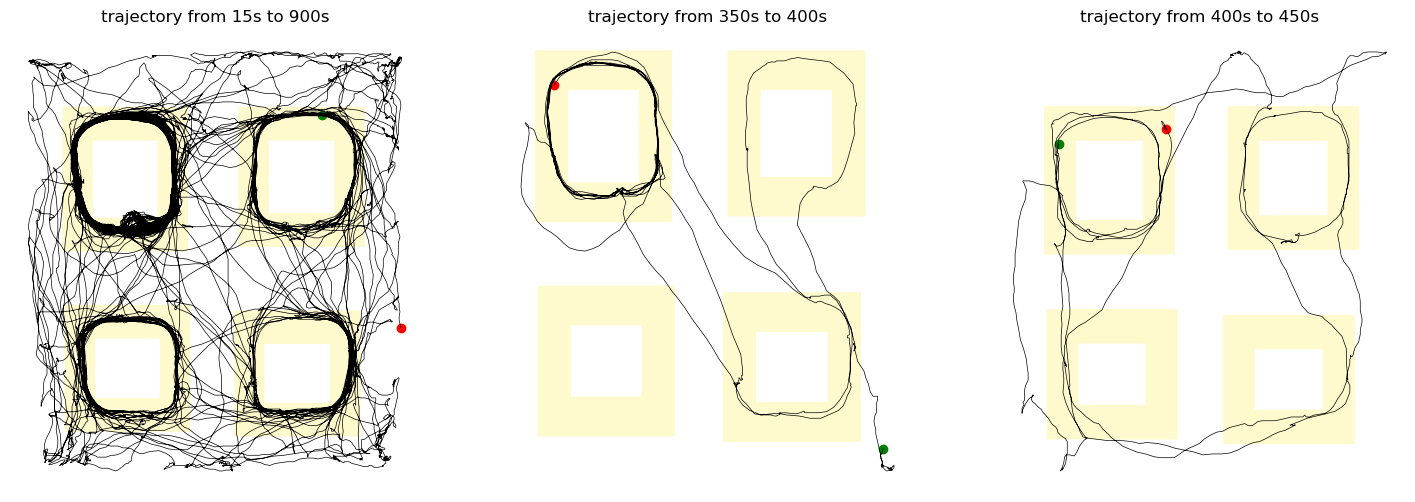

In [10]:
#this part MUST be run each time the program is launched or the session/epochs are changed
session='MOU4087_20230629-0950'

session_param = pd.read_csv(videoFolder_path + mouseName + '/' + session + '/' + session + "_sessionparam.csv")
session_direction = session_param['potentialRewardedDirections'][0]

time_analysis[0] = [15,session_param['durationOfExperiment'][0]]# add the time of the experiment. Will be used for graph legends and plotting

csvCentroid_fullpath=videoFolder_path + mouseName + '/' + session + '/' + session + '_centroidTXY.csv'
df=pd.read_csv(csvCentroid_fullpath) # transform csv file in panda dataframe
df=df.dropna() #supprime les lignes qvec un ou plusieurs NA
df=df.loc[df['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer

df=df[df['xposition'].between(1,500) & df['yposition'].between(1,500)] #on garde les valeurs entre 15 et 500 (le tableau est cree plus grand que necessaire)

size_of_df = len(df)#get some informations in a more convinent form
number_of_analysis = len(time_analysis)
time = df['time'].to_numpy()
xposition = df['xposition'].to_numpy()
yposition = df['yposition'].to_numpy()
yposition = Resolution[1] - yposition# yposition is inverted, put it back in the right way

#when_is_in_analysis define the part of the dataframe we are about to use. Its is a list of list
#np.where give the indice of the part which are in the given timeframe. 
#the last line stock the first and the last indice which fullfill this in a list.

when_is_in_analysis = []
for a in range(0, number_of_analysis) : #loop on time_analysis
    all_the_indices = np.where(np.logical_and(time > time_analysis[a][0], time < time_analysis[a][1]))
    when_is_in_analysis.append([np.min(all_the_indices), np.max(all_the_indices)])



def trapezes_from_patch(patch, width):
    """
    generate the trapezes coordinates surrounding a patch
    inputs:
    patch - coordinates of a patch [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]]
    width - width of the trapeze in pixels
    outputs:
    coordinates [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]] for the 4 trapezes.
    
    trapezes_from_patch(SWpatch_coords, 200)
    """

    N = [patch[0], patch[1], [patch[1][0]+width, patch[1][1]+width], [patch[0][0]-width, patch[0][1]+width]]
    E = [patch[1], patch[2], [patch[2][0]+width, patch[2][1]-width], [patch[1][0]+width, patch[1][1]+width]]
    S = [patch[2], patch[3], [patch[3][0]-width, patch[3][1]-width], [patch[2][0]+width, patch[2][1]-width]]
    W = [patch[3], patch[0], [patch[0][0]-width, patch[0][1]+width], [patch[3][0]-width, patch[3][1]-width]]
    return N, E, S, W

collection_trapeze = {"NW" : dict(), "NE" : dict(), "SW" : dict(), "SE" : dict()}#define the list of trapeze as a dictionnary containing  dictionnary to access them more easly

collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)



plt.figure(figsize= (6 * number_of_analysis, 6))#change the size of the figure to be printed to be larger

#the plot is comprised of one subplot which show the whole trajectory and one for every epoch
#plot the trajectories of the other epoch
for a in range(0, number_of_analysis):
    plt.subplot(1,number_of_analysis,a+1)#the subplot is 1 line tall, two columns width and the following lines will define the a+1 ieme graph
    for patch in collection_trapeze :
        for trapeze in collection_trapeze[patch] :
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color = "lemonchiffon")
            plt.gca().add_patch(shape)
    plt.plot(xposition[when_is_in_analysis[a][0] : when_is_in_analysis[a][1] + 1], yposition[when_is_in_analysis[a][0] : when_is_in_analysis[a][1] + 1], linewidth= 0.5, c= 'k') #when_is_in_analysis is used to know the indices of the axis 
    plt.scatter(xposition[when_is_in_analysis[a][0]], yposition[when_is_in_analysis[a][0]], c= "green")
    plt.scatter(xposition[when_is_in_analysis[a][1]], yposition[when_is_in_analysis[a][1]], c= "red")
    plt.title('trajectory from ' + str(time_analysis[a][0]) + 's to ' + str(time_analysis[a][1]) + 's')#print the time of beginng and end of periods
    
    
    plt.axis('off')
plt.show()

Define the following functions : 
Identity
get_epoch_small_analysis
plot_Whole_analysis
cut_in_epoch_speed
calcul_angle
calcul_angular_speed
get_time_average
show_epoch

In [11]:
#define get_epoch_small_analysis and plot_whole_analysis. Must be runed once before doing the following analysis


#give back the first argument  and epochs without any change
def identity(x, y = None, z = None, epochs = []) : return x, epochs

##################################################
#when working on a small trajectorie. epoch is the epochs of the whole trajectorie and when_is_in_analysis contain the indices of the small trajectory beginning and end
#Epochs are build under the format [indice of beginning, indice of end, informations]. When_is in_trajectory is the same but without informations.
def get_epoch_small_analysis( epochs, when_is_in_analysis) :

    epoch_of_small_trajectory = [] #will contain the eopchs for the small trajectory
    #loop on the epochs of the whole trajectory
    for u in range(len(epochs)):
        if (epochs[u][1] < when_is_in_analysis[0]) or ( epochs[u][0] > when_is_in_analysis[1]) : pass#if the epoch is outside the scope of the small trajectory, ignore it
        
        #if the epochs is at least partially in the field of the small trajectory, the beginning of the epoch to be kept is the maximum between the start of the epoch
        # and the start of the small trajectory. Inverse logic for the end. epochs[2] contain the informations on the epoch.
        else : 
            epoch_of_small_trajectory.append([max(epochs[u][0], when_is_in_analysis[0]), min(epochs[u][1], when_is_in_analysis[1]), epochs[2]])

    #print(str(len(epoch_of_small_trajectory)) + " epochs obtained " ) #take off the comment to print the number of epochs of the small trajectory
    return epoch_of_small_trajectory #return the eopchs for the small 




########################################
def plot_whole_analysis(xdata, ydata, param1_y, time_analysis , when_is_in_analysis ,
                        transformationX = identity, transformationY  = identity, param1_x = None, param2_x = None , param2_y = None, param3_x = None, param3_y = None,
                        mirror = False, 
                        in_epochs_after = False, in_epochs_before = False, epochs = [[0,0]],
                        #these argument are cosmetic
                        hide_axis = False, colors = ['dimgray'],  figure_height = 3, argumentsName = "Argument", argumentUnitY = "", argumentUnitX = "", 
                        superimposed_original = False, ylimit = None) :
    """
    xdata contain the non-transformed data you wish to plot according to the X axis. Typically position or time
    ydata ------------------------------------------------------------------ Y ----. Typically position speed or orientation.
    transformationX and transformationY are function which will be used to chqnge these axis. The default is the identity.
          They must be under the format (data, epochs, arg1 (optionnal for x), arg2(optionnal))       And give out the transformed data then the epochs (empty list if not used)
    param1_y is a list of parameters to be tried for the transformation
    set mirror = True if a list of parameters are to be tried also in x and use param1_x to give the list of parameters. If not param1_x is optionnal and will not be iterred upon
    param2_x, param3_x, param2_y and param3_y are always optionnal and will not be itterred upon
    time_analysis is a list of list undere the form [[beginning time of the first small trajectory, end time of the first small trajectory][beginning time of the second small trajectory, ....] ...]
    when_is_in_analysis is the same as time_analysis but with the indice of the information instead of the time
    in_epochs_after and in_epochs before are to know if the data to be plotted is in multiple epochs(true) or in a single block (false)
    set hide_axis to true if you want to hide the axis of the graphs, #colors is a list of color to use when ploting the graph on a given colors. if there are less colors than columns, the last one will be repated
    figure_height change the height/row of the plot 
    argumentsName, argumentUnitY and argumentUnitX are to change the legends of the graphs 
    superimposed_original is to indicate if you want to plot the original graph under your current
    ylimit is to set the limits of the y axis for the transformed data to keep them consistent. format : (ymin, ymax)
    """
    
    number_of_column = len(param1_y) + 1 ; number_of_rows = len(time_analysis) #get the sizes of the columns and rows, to avoid having to calculate them every time
    plt.figure(figsize = (18, figure_height * number_of_rows))#change the dimensions of the plot so there is place for every line
    if len(colors) < number_of_column : colors += [colors[-1]] * (number_of_column - len(colors))#ensure the color vector is long enough



    for a in range(0, number_of_rows) : #print every trajectory and subtrajectory without any transformation
    
        plt.subplot( number_of_rows, number_of_column, a*(number_of_column) + 1 ) #select the first graph of the current line

        #if the data are already cut into epochs
        if in_epochs_before :
            smaller_epochs = get_epoch_small_analysis(epochs= epochs, when_is_in_analysis = when_is_in_analysis[a])#get the epochs necessary for this small trajectory
            for u in smaller_epochs :
                plt.plot( xdata[u[0] : u[1]], ydata[u[0] : u[1]], linewidth = 0.5, c = colors[0] )#print every epoch of the small trajectory independently
        #if there is no epochs in theses datas, plot them
        else :
            plt.plot( xdata[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], ydata[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], linewidth = 0.5, c = colors[0] )
        plt.title("trajectory from " + str(time_analysis[a][0]) + 's to ' + str(time_analysis[a][1]) + 's')
        if hide_axis : plt.axis('off')
    

    for i in range(number_of_column - 1) :# an iteration = a column
        
        if type(param2_y) == type(None) : ytransformed, epochs = transformationY( ydata, epochs,param1_y[i]) #transform y according to the function and its arguments and get the epochs
        elif type(param3_y) == type(None) : ytransformed, epochs = transformationY( ydata, epochs, param1_y[i], param2_y) 
        else : ytransformed, epochs = transformationY( ydata, epochs, param1_y[i], param2_y, param3_y) 

        if mirror : #transform x according to the function and its arguments. ignore the epochs, they are obtained with ytransformed
            if type(param2_x) == type(None) : xtransformed, _ = transformationX(xdata, epochs, param1_x[i]) 
            elif type(param3_x) == type(None): xtransformed, _ = transformationX(xdata, param1_x[i], param2_x)
            else : xtransformed, _ = transformationX(xdata, param1_x[i], param2_x, param3_x)
        else : 
            if type(param1_x) == type(None) : xtransformed, _ = transformationX(xdata, epochs)
            elif type(param2_x) == type(None) : xtransformed, _ = transformationX(xdata, epochs, param1_x)
            elif type(param3_x) == type(None) : xtransformed, _ = transformationX(xdata, epochs, param1_x, param2_x)
            else : xtransformed, _ = transformationX(xdata, epochs, param1_x, param2_x, param3_x)

        
        for a in range(number_of_rows): # an iteration = a plot on the column
            plt.subplot( number_of_rows, number_of_column, number_of_column * a + (i + 1) + 1)#to get the position of the current graph : size of column * current row (starting at 0) + number of the column in the current row
            if superimposed_original :#if true, plot a the original data on the first graph
                if in_epochs_before :
                    smaller_epochs = get_epoch_small_analysis(epochs= epochs, when_is_in_analysis = when_is_in_analysis[a])#get the epochs necessary for this small trajectory
                    for u in smaller_epochs :
                        plt.plot( xdata[u[0] : u[1]], ydata[u[0] : u[1]], linewidth = 0.5, c = colors[0] )#print every epoch of the small trajectory independently
                #if there is no epochs in theses datas, plot them
                else :
                    plt.plot( xdata[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], ydata[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], linewidth = 0.5, c = colors[0] )
            
                    
            if in_epochs_after :#plot the transformed data
                smaller_epochs = get_epoch_small_analysis(epochs= epochs, when_is_in_analysis = when_is_in_analysis[a])#get the epochs necessary for this small trajectory
                print(str(len(smaller_epochs)) + " epochs, argument = " + str(param1_y[i])) #if you want to know the number of epochs in the small trajectory
                for u in smaller_epochs :
                    plt.plot( xtransformed[u[0] : u[1]], ytransformed[u[0] : u[1]], linewidth = 0.5, c = colors[i+1])
            else :
                plt.plot( xtransformed[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], ytransformed[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], linewidth = 0.5, c = colors[i+1] )
            

            if type(ylimit) != type(None) : plt.ylim(ylimit)
            if mirror and a==0: plt.title( argumentsName + "  X = " + str(param1_x[i]) + argumentUnitX+ " Y = " + str(param1_y[i]) + argumentUnitY)
            elif a == 0 : plt.title(argumentsName + " = " + str(param1_y[i]) + argumentUnitY)
            if hide_axis : plt.axis('off')

    plt.show()
    return

##################################################
#function which take the speed qnd the time of the trajectory as well as the parameters for the cut : the minimum speed to cut and send back a list of list which is a list of all epoch. 
#an epoch is a list of point. A point is defined by its position in the array 'time'

def cut_in_epoch_speed(ydata, epochs, cut_off_speed, speed_values, time): #the epochs in entry are not used, they're just necessary for the format
    """
    cut the trajectory into different part where the animal is moving
    """
    list_of_epochs = []
    speed_size = len(speed_values)
    beginning_epoch = 0

    if speed_size != len(time) : raise ValueError("speed and time have different length")

    for i in range(speed_size) : #
        if speed_values[i] >= cut_off_speed : #if the speed is above the cut-off value
            if beginning_epoch ==0 : beginning_epoch = i #if there were no epoch being studied, this is the beginning of the epoch
        elif beginning_epoch == 0 : pass #if we were not in an epoch, failure to be above the threshold does nothing
        elif list_of_epochs!=[] and (time[beginning_epoch] - time[list_of_epochs[-1][1]] < MINIMAL_DURATION_STOP) : #if the interval with the previous epoch was too short, change its end to the end of this epoch
            list_of_epochs[-1][1] = i-1 ; beginning_epoch = 0
        
        else :
            
            list_of_epochs.append([beginning_epoch, i-1, "N", 0])#by default, every epoch is noted "N" for "not a quarter turn"
            beginning_epoch = 0


    if beginning_epoch == 0 : pass #once the loop is ended check if there is a suitable epoch in memory
    elif list_of_epochs!=[] and (time[beginning_epoch] - time[list_of_epochs[-1][1]] < MINIMAL_DURATION_STOP) : #if the interval with the previous epoch was too short, change its end to the end of this epoch
            list_of_epochs[-1][1] = i-1 ; beginning_epoch = 0
    elif (time[speed_size - 1] - time[beginning_epoch]) < MINIMAL_DURATION_EPOCH : pass
    else :
        list_of_epochs.append([beginning_epoch, speed_size - 1, "N", 0]) #the N at the end is for "not a quarter turn". every epoch is not a quarter turn until proven otherwise
        

    size_len_epoch = len(list_of_epochs) ; a =0#check if the epoch is long enough
    while a < size_len_epoch:           
        if (time[list_of_epochs[a][1]] - time[list_of_epochs[a][0]]) < MINIMAL_DURATION_EPOCH : 
            _ = list_of_epochs.pop(a) #if the epoch is too short to be considerded, discard it
            size_len_epoch -= 1 
        else : a+= 1
    
    for i in range(len(list_of_epochs)) :
        current_point = list_of_epochs[i][0] #get the current beginning of the epoch
        acceleration = (speed_values[current_point + 1] - speed_values[current_point]) / (time[current_point + 1] - time[current_point])
        try :
            previous_acceleration = (speed_values[current_point ] - speed_values[current_point - 1]) / (time[current_point] - time[current_point - 1])
        except :
            previous_acceleration = -1#if this is the first point, there is no previous acceleration, so don't go in the loop

        while previous_acceleration > (0.4 * acceleration) and previous_acceleration > 0:#continue to go further until we reach the end of the acceleration
            current_point = current_point - 1
            try : previous_acceleration = (speed_values[current_point ] - speed_values[current_point - 1]) / (time[current_point] - time[current_point - 1])
            except : previous_acceleration = -1#if this is the first point, there is no previous acceleration, so break out of the loop
        list_of_epochs[i][0] = current_point#change the beginning of the epoch for the beginning of the acceleration


        current_point = list_of_epochs[i][1] #get the current end of the epoch
        try : acceleration = (speed_values[current_point + 1] - speed_values[current_point]) / (time[current_point + 1] - time[current_point])#calculate the acceleration of the segment just AFTER the end of the epoch
        except : acceleration = 1
        previous_acceleration = (speed_values[current_point ] - speed_values[current_point - 1]) / (time[current_point] - time[current_point - 1])#calculate the acceleration of the segment just BEFORE the end of the epoch

        while acceleration < (0.4 * previous_acceleration)  and acceleration < 0:
            current_point = current_point + 1
            try : acceleration = (speed_values[current_point + 1] - speed_values[current_point]) / (time[current_point + 1] - time[current_point])
            except : acceleration = 1
        #change the end of the epoch for the end of the decceleration
        list_of_epochs[i][1] = current_point


    for i in range(len(list_of_epochs)) : list_of_epochs[i][3] = i
    
    return ydata, list_of_epochs


############################################
#for every point after the first, create a imaginary number where the real part is equal to difference in x coodinates, while the imaginary part is the same but with y positions.
#this number is transformed into angles in degree with np.angle
#angles = np.array(np.angle([(xpositions[i]- xpositions[i-1]) + ((ypositions[i] - ypositions[i-1])) * 1j for i in range(1, len(xpositions))], deg= True))
def calcul_angle(ycoordinate, epochs, ecart, xcoordinate ) :
    angles  = np.array([np.angle(xcoordinate[i]- xcoordinate[i-ecart] + (ycoordinate[i] - ycoordinate[i-ecart]) * 1j , deg= True) for i in range(ecart, len(xcoordinate))])
    angles = np.insert(angles, obj= 0, values= np.zeros(ecart ))#the calcul of angles change the size of the data. To avoid it, add as much time the first value
    epochs = [[epoch[0]+ecart, epoch[1], epoch[2], epoch[3]] for epoch in epochs if (epoch[1] - epoch[0]) > ecart]#in order to be sure to only compute datas from inside the epochs, cut the beginning of the epochs
    
    return angles, epochs #return the orientation of the mouse across time and the modified epochs

##########################################
def calcul_angular_speed(ycoordinate, epochs, ecart, xcoordinate, time ): #function which get the angular speed for a given ecart, in order to be ploted with plot_whole_analysis
    angles, epochs = calcul_angle(ycoordinate, epochs, ecart, xcoordinate)
    time_average = np.array([time[0]]*ecart + [(time[i] + time[i-ecart]) /2 for i in range(ecart, len(time))])
    angles_relatifs = np.insert(np.diff([angles, time_average])[0], obj= 0, values= np.zeros(1 )) #derive les angles par rapport au temps
    angular_speed = [360  + x if x < -180 else -360 + x if x>180 else x for x in angles_relatifs] #correct for the casses when angle go from -180 to 180 and vice-versa

    return angular_speed, epochs

#############################################
def get_time_average(time, epochs, ecart) :#get the time average, transformation necessary for plot_whole_analysis
    time_average = np.array([time[0]]*ecart + [(time[i] + time[i-ecart]) /2 for i in range(ecart, len(time))])
    return time_average, epochs

###########################################
def show_epoch(epoch_number, xcoordinate, ycoordinate, speed, angular_speed, orientation, time, list_epochs, timeofframes, time_average, mouse, session, session_direction) :
    epoch = list_epochs[epoch_number - 1]
    epoch_one_plus_one = epoch[1] + 1
    plt.figure(figsize=(8,8))

    plt.subplot(2, 2, 1)#the first subplot show the trajectory
    for object_angle in NWpatch_coords : #plot the angle of every object 
        plt.scatter(object_angle[0], object_angle[1], c= 'k')
    for object_angle in NEpatch_coords : 
        plt.scatter(object_angle[0], object_angle[1], c= 'k')
    for object_angle in SWpatch_coords : 
        plt.scatter(object_angle[0], object_angle[1], c= 'k')
    for object_angle in SEpatch_coords : 
        plt.scatter(object_angle[0], object_angle[1], c= 'k')

    plt.plot(xcoordinate[epoch[0] : epoch_one_plus_one], ycoordinate[epoch[0] : epoch_one_plus_one], c= "aquamarine")#plot the trajectory during the epoch
#plot a point on the trajectpry every 0.25s
    next_point = time[epoch[0]] + 0.25 ; points = []
    for a in range(epoch[0], epoch_one_plus_one):
        if time[a] >= next_point :
            plt.scatter(xcoordinate[a], ycoordinate[a], c= "grey")
            points.append(time[a])
            next_point = time[a] + 0.25
    plt.scatter( xcoordinate[epoch[0]], ycoordinate[epoch[0]], c= "green")#plot the first point of the trajectory
    plt.scatter(xcoordinate[epoch[1]], ycoordinate[epoch[1]], c= "firebrick")#plot the last point of the trajectory
    plt.title("trajectory")
    plt.xlim(0, 500); plt.ylim(0,500); plt.axis('off')

    
    ax = plt.subplot(2, 2, 2)# the second subplot show the speed across time
    for a in points:
        plt.axvline(a, c = 'grey', zorder = 1)
    plt.plot(timeofframes[epoch[0] : epoch_one_plus_one], speed[epoch[0] : epoch_one_plus_one], c= "darkorchid", zorder = 2)
    plt.scatter(timeofframes[epoch[0] : epoch_one_plus_one], speed[epoch[0] : epoch_one_plus_one], c = angular_speed[epoch[0] : epoch_one_plus_one], cmap = "cool", zorder = 2)
    plt.xlabel("time in s") ; plt.ylabel("speed in cm/s"); plt.title("speed") ; ax.spines[['right', 'top']].set_visible(False)
    plt.ylim(bottom = 0)

    ax = plt.subplot(2, 2, 3)#the third subplot show the orientation
    for a in points:
        plt.axvline(a, c = 'grey', zorder = 1)
    plt.scatter(time_average[epoch[0] : epoch_one_plus_one], orientation[epoch[0] : epoch_one_plus_one], c= "cadetblue", zorder = 2)
    plt.scatter(time_average[epoch[0] : epoch_one_plus_one], orientation[epoch[0] : epoch_one_plus_one] - 360, c= "cadetblue", zorder = 2)
    plt.xlabel("time in s") ; plt.ylabel("orientation of the mouse"); plt.title("orientation"); plt.yticks([-450, -360, -270, -180, -90, 0, 90])
    plt.ylim(-540,180); plt.grid(axis = 'y'); ax.spines[['right', 'top']].set_visible(False)

    ax = plt.subplot(2, 2, 4)#the fourth subplot show the angular speed
    for a in points:
        plt.axvline(a, c = 'grey', zorder = 1)
    plt.plot(time_average[epoch[0] : epoch_one_plus_one], angular_speed[epoch[0] : epoch_one_plus_one], c= "peru")
    plt.scatter(time_average[epoch[0] : epoch_one_plus_one], angular_speed[epoch[0] : epoch_one_plus_one], c= speed[epoch[0] : epoch_one_plus_one], cmap= 'cool')
    plt.xlabel("time in s") ; plt.ylabel("amgular speed in degree/s"); plt.title("angular speed") ; ax.spines[['right', 'top']].set_visible(False)
    plt.ylim(-40, 40)

    plt.suptitle(mouse + " direction " + str(session_direction) + " session : " + session + "\nepoch " + str(epoch_number) + " " +epoch[2])
    plt.tight_layout()
    plt.show()
    return

#############################################################
def show_cut_epoch(speed, time, epochs, when_is_in_analysis) :
    """
    show in a graph which part of the speed profile of the time in amalysis were counted in an epoch and which were not
    speed/time are the array containing the speed/time of all the frames in the session
    epochs is the list of the epochs during the whole session, obtained using cut_in_epoch_speed()
    when_is_in_analysis is a list of two elements containing the indices corresponding to the beginning and end of the moment to analyse
    """
    new_epoch = get_epoch_small_analysis(epochs, when_is_in_analysis)#get the epochs corresponding to the small-scale analysis

    plt.figure(figsize=(20, 5))#give the dimensions of the figure 

    plt.plot( time[when_is_in_analysis[0] : new_epoch[0][0] + 1], speed[when_is_in_analysis[0] : new_epoch[0][0] + 1] , linewidth = 0.5, c= "green")#print the eventual non-epoch part before the beginning of the first epoch
    #loop on the epochs, plot the epoch in red then the space between it and the next epoch in green
    for i in range(len(new_epoch) - 1) :
        plt.plot(time[new_epoch[i][0] : new_epoch[i][1] + 1], speed[new_epoch[i][0] : new_epoch[i][1] + 1] , linewidth = 0.5, c = "red")
        plt.plot(time[new_epoch[i][1] : new_epoch[i+1][0] + 1], speed[new_epoch[i][1] : new_epoch[i+1][0] + 1], linewidth = 0.5, c= "green")
    #plot the last epoch
    plt.plot(time[new_epoch[-1][0] : new_epoch[-1][1] + 1], speed[new_epoch[-1][0] : new_epoch[-1][1] + 1] , linewidth = 0.5, c = "red", label = "epoch")
    #plot the eventual last non-epoch
    plt.plot(time[new_epoch[-1][1] : when_is_in_analysis[1]], speed[new_epoch[-1][1] : when_is_in_analysis[1]], linewidth = 0.5, c= "green", label = 'immobility')

    plt.title("how the epochs were cut")
    plt.legend()
    plt.show()


######################
def coordinate_patch(patch): #give a y coordinate corresponding to the 
    
    """ give the number corresponding to the patch. Patch must be either 'SW', 'NW', 'SE' or 'NE' """

    if patch == "NE" : return 1
    elif patch == "NW" : return 2
    elif patch == "SE" : return 3
    else : return 4

    
###############################
def search_right_turn(time_start, time_end, dinfo,):
    

    for i in range(len(dinfo)) :
        if dinfo.loc[dinfo.index[i], "time"] > time_start and dinfo.loc[dinfo.index[i], "time"] < time_end : #if the time of the turn is comprised between the beginning and the end of the epoch
            return dinfo.loc[dinfo.index[i], "maxNberOfConsecRewards"]#return the number of max rewards of the serie
    return -1

do all the basic analysis : calculate the distance between points, the speed, the orientation, the angular speed
does the first two transformationb : smoothing filter and cutting the trajectory in epochs according to speed

In [12]:
#compute the distance between consecutive points
distances=np.array([((((xposition[i]-xposition[i-1])**2)+((yposition[i]-yposition[i-1])**2))**0.5) for i in range(1,len(yposition))]) 
distances = distances *(0.84/Resolution[0]) #convert distance to m with apparatus length =84cm


xgauss = smooth(xposition, true_sigma) ; ygauss = smooth(yposition, true_sigma)#smooth the positions with true sigma

# compute the distance but on the data with the gaussian filter
distances_gauss = np.array([((((xgauss[i]-xgauss[i-1])**2)+((ygauss[i]-ygauss[i-1])**2))**0.5) for i in range(1,len(yposition))]) 
distances_gauss = distances_gauss *(0.84/Resolution[0])

print(' total distance without Gaussian filter : ', np.sum(distances), '\n total distance with the filter On : ',  np.sum(distances_gauss))


#because the distance is computed using two points, it does no longer correspond to time. To fix it, the average of the time used the calculate the distance is used
timeofframes= np.array([time[0]] + [(time[i] + time[i-1]) /2 for i in range(1, len(time))])

timebeweenframe=np.diff(time)#get the gap between the frames
#compute the speed in m/s, using both the distance for the original data and the smoothen one
speeds_original =np.divide(distances,timebeweenframe)
speeds_gauss =np.divide(distances_gauss,timebeweenframe)
#get the speed in cm/s and add a speed of 0 at the beginning to keep the same data size
speeds_original = np.insert(speeds_original, 0, 0) * 100
speeds_gauss = np.insert(speeds_gauss, 0, 0) * 100
_, list_epochs = cut_in_epoch_speed(yposition, [], true_cut_speed, speed_values = speeds_gauss, time = time) #calculate the epochs with the true cut_off speed and store it


#calculate the orientation with the chosen value and get the changed epochs
angles, list_epochs_angle = calcul_angle(ycoordinate= ygauss, epochs= list_epochs, ecart= true_ecart_angle, xcoordinate= xgauss)
time_average = np.array([time[0]]*true_ecart_angle + [(time[i] + time[i-true_ecart_angle]) /2 for i in range(true_ecart_angle, len(time))])

angles_relatifs = np.insert(np.diff([angles, time_average])[0], obj= 0, values= np.zeros(1 )) #derive les angles par rapport au temps
angular_speed = [360  + x if x < -180 else -360 + x if x>180 else x for x in angles_relatifs] #correct for the brutal acceleration when angle pass from -180 to 180

#calcul of acceleration
acceleration = np.insert(np.diff([speeds_gauss, time_average])[0], obj = 0, values= np.zeros(1))#derive speed relative to time


 total distance without Gaussian filter :  141.1333107154509 
 total distance with the filter On :  134.2580943570852


Advance analysis = identify the quarter turns, the trajectory towards and between objetcs
format of a quarter turn indicator : [0] = 'Q' for quarter turn     [1] = 'k'/'w' for counterclockwise / clockwise   [2] = 'O'/'E'/'B'/'G'/'H' for wrong object /extra turn / bad direction / Good / double wrong             [3-4] = patch                                                                                                                

In [13]:
csvTurnsinfo_fullpath=videoFolder_path + mouseName + '/' + session + '/' + session + '_turnsinfo.csv'#get the information on the turns in the dataframe dinfo
dinfo=pd.read_csv(csvTurnsinfo_fullpath) # transform csv file in panda dataframe
#dinfo=dinfo.dropna() #il ne faut surtout pas drop les NA
for i in range(df.index.values[0], dinfo.index.values[-1]):#if there is a missing value for ongoingRewardedObject, replace it with either SW or SE, as long as it's not the one where the mouse is
    if (type(dinfo['ongoingRewardedObject'][i]) == float) :
        dinfo['ongoingRewardedObject'][i] = str([dinfo['currentPatch'][i]]) 

dinfo=dinfo.loc[dinfo['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer


#position of the different objects
#             ------      ------
#             | NW |      | NE |
#             ------      ------
#
#             ------      ------
#             | SW |      | SE |
#             ------      ------




def whichPatch(number) :
    """send back the string indicating the current patch based on the number recieved
        # 0 = 'SW', 1 = 'NW', 2 = 'SE', 3 = 'NE'
    """
    if number == 0 : return "NE"
    elif number == 1 : return "NW"
    elif number == 2 : return "SE"
    else : return "SW"

def is_in_a_goal(xposition, yposition, current_patch, dictionnaire_of_goals) :
    """
    for every goal in the list, test if the position is inside using points_in_polygon. return a bool
    """

    in_a_trapeze = False
    for i in dictionnaire_of_goals[current_patch] :
        if points_in_polygon(polygon= dictionnaire_of_goals[current_patch][i], pts = [[xposition, yposition]]) :
            in_a_trapeze = True
    return in_a_trapeze

def stay_in_patch(patch, xpositions, ypositions) :
    """ check if the point change patch at a given moment. Patch must be either 'SW', 'NW', 'SE' or 'NE' """
    stay_in_place = True
    indice = 0 ; max_indice = len(xpositions)

    patch = coordinate_patch(patch) - 1

    while indice < max_indice and stay_in_place :#check for every point of the trajectory if they are in a different patch than the first one
                    if patch != (xpositions[indice] < Resolution[0] / 2) * 1 + (ypositions[indice] < Resolution[1] / 2) * 2 :
                        stay_in_place = False
                    indice += 1

    return stay_in_place





not_in_an_epoch = []
in_an_epoch_but_no_quarter = [] #will contain a list under the form [time, corresponding epoch, bool rewarded]

for a in range(len(dinfo)):#the epochs are written as "not a quarter" by default. We just need to change it for those which are
    not_past_nor_found = True; i = 0; turn_time = dinfo.loc[dinfo.index[a], "time"]
    if time[list_epochs[-1][1]] < turn_time : #if the last epoch end before the recorded turn, discard the turn
        not_in_an_epoch += [turn_time]
        not_past_nor_found = False
    
    while not_past_nor_found :
        if time[list_epochs[i][1]] < turn_time : i+=1 #if the end of the epoch is before the time of the turn, the epoch does not contain the turn so try the next epoch. We work with the original list of epochs
        elif time[list_epochs[i][0]] > turn_time :#if we reach a point where the beginning of the epoch is after the turn, then the turn was not in an epoch
            not_in_an_epoch += [turn_time]
            not_past_nor_found = False
        else : #if the time is in this epoch, test if this is a true quarter turn
                #check if the beginning of the epoch (movement) is in the polygon it's supposed to                                                                             #check if the beginning of the epoch (movement) is in the polygon it's supposed to 
            
            if points_in_polygon(polygon= collection_trapeze[dinfo.loc[dinfo.index[a], "currentPatch"]][dinfo.loc[dinfo.index[a], "previousTrapeze"]], pts = [[xgauss[list_epochs[i][0]], ygauss[list_epochs[i][0]]]]) and points_in_polygon(polygon = collection_trapeze[dinfo.loc[dinfo.index[a], "currentPatch"]][dinfo.loc[dinfo.index[a], "currentTrapeze"]], pts= [[xgauss[list_epochs[i][1]], ygauss[list_epochs[i][1]]]]) :
                #current patch is obtained from a number between 0 and 3 indicating in which patch it is (True = 1, False = 0)
                current_patch = whichPatch((xgauss[list_epochs[i][0]] < Resolution[0] / 2) * 1 + (ygauss[list_epochs[i][0]] < Resolution[1] / 2) * 2)

                #check if the mouse does not go to another patch. If it does, it is not a quarter turn
                if stay_in_patch(current_patch, xgauss[list_epochs[i][0] : list_epochs[i][1] + 1], ygauss[list_epochs[i][0] : list_epochs[i][1] + 1]) :
                    if int(dinfo.loc[dinfo.index[a], "turnDirection"]) == 90 : w_turn = "k"  #add a marker depending of the type of turn
                    else : w_turn = "w"

                    #select the type of turn 
                    if len(dinfo.loc[dinfo.index[a], "typeOfTurn"]) == 6 : t_turn = 'E' #E stand for Extra turn
                    elif dinfo.loc[dinfo.index[a], "typeOfTurn"][0] == 'b' : 
                        if dinfo.loc[dinfo.index[a], "typeOfTurn"][2] == 'b' :t_turn = 'H' #H for horrible (neither good direction nor good good object)
                        else : t_turn = 'O' # O stand for wrong Object
                    elif dinfo.loc[dinfo.index[a], "typeOfTurn"][2] == 'b' : t_turn = 'B'# B stand for Bad turn
                    else : t_turn = 'G' # G stands for Good turn

                    list_epochs[i][2] = "Q" + w_turn + t_turn + current_patch# Q for quarter turn. 
                else : in_an_epoch_but_no_quarter += [(turn_time, i, dinfo.loc[dinfo.index[a], "Rewarded"])]
            else : 
                in_an_epoch_but_no_quarter += [(turn_time, i, dinfo.loc[dinfo.index[a], "Rewarded"])]

            not_past_nor_found = False # the correct epoch was found, no need to continue

for a in range(len(list_epochs)) :
    if list_epochs[a][2][0] == "N" : #if the epoch is not a quarter_turn, look at if it can be either a movement between objects or a movement towards an object
        #current patch is a number between 0 and 3 indicating in which patch it is (True = 1, False = 0)
        # 0 = NE, 1 = NW, 2 = SE, 3 = SW
        current_patch = whichPatch((xgauss[list_epochs[a][1]] < Resolution[0] / 2) * 1 + (ygauss[list_epochs[a][1]] < Resolution[1] / 2) * 2)        
        
        #if the epoch end in a trapeze it's either a movement towards an object or a movement between objects, or a very small exploration epoch
        if is_in_a_goal(xgauss[list_epochs[a][1]], ygauss[list_epochs[a][1]], current_patch, collection_trapeze) :
            previous_patch = whichPatch((xgauss[list_epochs[a][0]] < Resolution[0] / 2) * 1 + (ygauss[list_epochs[a][0]] < Resolution[0] / 2) * 2)
            
            #check if the beginning of the epoch was also in a trapeze
            if is_in_a_goal(xgauss[list_epochs[a][0]], ygauss[list_epochs[a][0]], previous_patch, collection_trapeze) :
                if current_patch == previous_patch :
                    #we consider two possibilities in this case : either this is a small exploration trajectory or 
                    # the animal move to multiple objects while trying to find the reward and end in the same patch in a between object trajectory
                    if not stay_in_patch(current_patch, xgauss[list_epochs[a][0] : list_epochs[a][1] + 1], ygauss[list_epochs[a][0] : list_epochs[a][1] + 1]) :
                        #then it's a between object trajectory
                        list_epochs[a][2] = "B" + previous_patch + current_patch + 'n' # n for n rewards
                    #else nothing, the exploratory trajectory are marked by an 'N' Which is the default
                
                #if previous_patch and current patch are different, it's a trajectory between object
                else : list_epochs[a][2] = "B" + previous_patch + current_patch + 'n' # n for no rewards
            #if the beginning of the epoch is not in a goal, it is considered a trajectory toward an object
            else : list_epochs[a][2] = "T" + current_patch


################################

for i in in_an_epoch_but_no_quarter :
    
    #consider only the turns which are made in a between object epoch
    if list_epochs[i[1]][2][0] == "B" :

        if i[2] : list_epochs[i[1]][2] = list_epochs[i[1]][2][0:5] + 'r' #if the turn was rewarded, change the last indicator to 'r' for rewarded
        else : list_epochs[i[1]][2] = list_epochs[i[1]][2][0:5] + 'n' #if the turn was not rewarded, change the last indicator to 'n' for rewarded

#because the epoch are treated in sequential order, in the cases where there are multiple turns in a between object trajectory,
# the indidactor is set to the last detected turn
                     
                
###########################################################################################################################################################        

#recalculate the epochs for list_epochs_angles so they have the right marking too
_, list_epochs_angle = calcul_angle(ycoordinate= ygauss, epochs= list_epochs, ecart= true_ecart_angle, xcoordinate= xgauss)


list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"]#get the list of all quarter turn
list_between_object = [epoch for epoch in list_epochs if epoch[2][0] == "B"]#get all trajecotory between objects
list_toward_object = [epoch for epoch in list_epochs if epoch[2][0] == "T"]#get all trajecotory towards objects
list_movement_not_quarter = [epoch for epoch in list_epochs if epoch[2][0] == "N"]#get all trajectory which are exploration

clock_turn = {'total' : [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]}#dividie the quarter turn depending on their direction. clock_turn and anti_clock_turn are dictionary
anti_clock_turn = {'total' : [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]}

#get a list for every direction contraining the epochs correponding to this type of turn
clock_turn['extraTurn'] = [epoch for epoch in clock_turn['total'] if epoch[2][2] == "E"] ; clock_turn['badDirection'] = [epoch for epoch in clock_turn['total'] if epoch[2][2] == "B"]
clock_turn['wrongObject'] = [epoch for epoch in clock_turn['total'] if epoch[2][2] == "O"]; clock_turn['Good'] = [epoch for epoch in clock_turn['total'] if epoch[2][2] == "G"]

anti_clock_turn['extraTurn'] = [epoch for epoch in anti_clock_turn['total'] if epoch[2][2] == "E"] ; anti_clock_turn['badDirection'] = [epoch for epoch in anti_clock_turn['total'] if epoch[2][2] == "B"]
anti_clock_turn['wrongObject'] = [epoch for epoch in anti_clock_turn['total'] if epoch[2][2] == "O"]; anti_clock_turn['Good'] = [epoch for epoch in anti_clock_turn['total'] if epoch[2][2] == "G"]

clock_angular_speed = [angular_speed[i] for u in clock_turn["total"] for i in range(u[0], u[1] + 1) ] ; anti_angular_speed = [angular_speed[i] for u in anti_clock_turn["total"] for i in range(u[0], u[1] + 1)]
clock_speed = [speeds_gauss[i] for u in clock_turn["total"] for i in range(u[0], u[1] + 1)] ; anti_clock_speed = [speeds_gauss[i] for u in anti_clock_turn["total"] for i in range(u[0], u[1] + 1)]
list_of_stops = [[list_epochs[a - 1][1 ] + 1, list_epochs[a][0] - 1] for a in range(1, len(list_epochs))]


#creat a dictionnary which can hold the different type of stops
stops_type = {"quarter_rewarded" : {"quarter" : [], "between" : [], "other" : []},
              "quarter_no_reward" : {"quarter" : [], "between" : [], "other" : []},
              "between_rewarded" : {"quarter" : [], "between" : [], "other" : []},
              "between_no_reward" : {"quarter" : [], "between" : [], "other" : []}
              }
#the value kept in the list are a list of the beginning epoch of the stop and end of the stop


for i in range(len(list_epochs) - 1) :
    if list_epochs[i][2][0] == "Q" : #if this is a quarter turn
        if list_epochs[i][2][2] == "G" :#if this is a good turn and thus a rewarded quarter turn

            if list_epochs[i + 1][2][0] == "Q" : #this followed by a quarter turn
                stops_type["quarter_rewarded"]["quarter"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            elif list_epochs[i + 1][2][0] == "B" :#this followed by a between object
                stops_type["quarter_rewarded"]["between"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            else : stops_type["quarter_rewarded"]["other"].append([list_epochs[i][1], list_epochs[i + 1][0]]) #this is followed by an exploration

        else : #then the quarter turn was not rewarded
            if list_epochs[i + 1][2][0] == "Q" : #this followed by a quarter turn
                stops_type["quarter_no_reward"]["quarter"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            elif list_epochs[i + 1][2][0] == "B" :#this followed by a between object
                stops_type["quarter_no_reward"]["between"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            else : stops_type["quarter_no_reward"]["other"].append([list_epochs[i][1], list_epochs[i + 1][0]]) #this is followed by an exploration

    elif list_epochs[i][2][0] == "B" :#if the epoch is a trajectory between object
        if list_epochs[i][2][5] == 'r' : #if the trajectory was rewarded

            if list_epochs[i + 1][2][0] == "Q" : #this followed by a quarter turn
                stops_type["between_rewarded"]["quarter"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            elif list_epochs[i + 1][2][0] == "B" :#this followed by a between object
                stops_type["between_rewarded"]["between"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            else : stops_type["between_rewarded"]["other"].append([list_epochs[i][1], list_epochs[i + 1][0]]) #this is followed by an exploration
        
        else : #the trajectory was not rewarded
            if list_epochs[i + 1][2][0] == "Q" : #this followed by a quarter turn
                stops_type["between_no_reward"]["quarter"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            elif list_epochs[i + 1][2][0] == "B" :#this followed by a between object
                stops_type["between_no_reward"]["between"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            else : stops_type["between_no_reward"]["other"].append([list_epochs[i][1], list_epochs[i + 1][0]]) #this is followed by an exploration

    #if this is not one of those, do nothing

quarter_after_reward = [a for a in range(1, len(list_epochs)) if list_epochs[a][2][0] == "Q" and ((list_epochs[a - 1][2][0] == "Q" and list_epochs[a - 1][2][2] == "G") or (list_epochs[a - 1][2][0] == "B" and list_epochs[a - 1][2][5] == "r"))]
quarter_after_nothing = [a for a in range(1, len(list_epochs)) if list_epochs[a][2][0] == "Q" and ((list_epochs[a - 1][2][0] == "Q" and list_epochs[a - 1][2][2] != "G") or (list_epochs[a - 1][2][0] == "B" and list_epochs[a - 1][2][5] == "n"))]
quarter_after_exploration = [a for a in range(1, len(list_epochs)) if list_epochs[a][2][0] == "Q" and list_epochs[a - 1][2][0] != "Q" and list_epochs[a - 1][2][0] != "B"]

TypeError: object of type 'numpy.int64' has no len()

show the quarter turns and between objects

<function matplotlib.pyplot.show(close=None, block=None)>

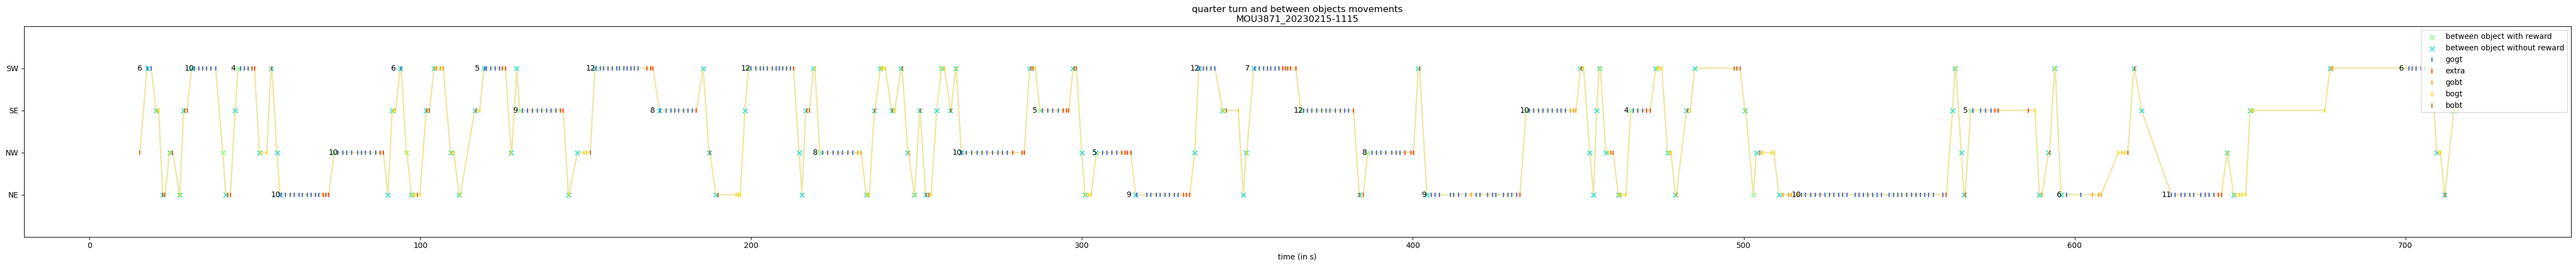

In [9]:
#four lines, one for each object
#plot the quarter turn ( rewarded, bad direction, bad object, extra turn) and the between object (rewarded or non-rewarded) One color for each type, must be easly readable
#the dot for quarter turn must appear at the location of the beginning and the end of it
#the time of the epoch is set at its beginning. The end point of the between object is at the end of the epoch (last indice)
#idealy, creat a line which indicate how the mouse move from one object to the other

#creat a list for each type of quarter turn
rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
extra = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'E']
badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']
wrongObject = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'O']
doubleWrong = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'H']

between_reward = [epoch for epoch in list_between_object if epoch[2][5] == 'r']
between_no_reward = [epoch for epoch in list_between_object if epoch[2][5] == 'n']


list_number_reward = []
serie = 0#will indicate if we are in a serie
current_quarter_turn = -1

for epoch in list_epochs :
    if epoch[2][0] == "Q" :
        current_quarter_turn += 1#add the number of the current quarter turn after so it still indicate the last one of the serie when added
        if epoch[2][2] == 'G': #if there is a good quarter turn, enter or continu a serie
            
            if serie == 0 : #add the signal at the beginning of the serie
                list_number_reward.append([current_quarter_turn, search_right_turn(time_start= time[list_quarter_turn[current_quarter_turn][0]], time_end= time[list_quarter_turn[current_quarter_turn][1]], dinfo = dinfo)])
                serie = 1

            #serie = 1

        #elif serie == 1 : #if the epoch is not a rewarded quarter turn
            #list_number_reward.append([current_quarter_turn - 1, search_right_turn(time_start= time[list_quarter_turn[current_quarter_turn][0]], time_end= time[list_quarter_turn[current_quarter_turn][1]], dinfo = dinfo)])
        #    serie = 0

    elif serie == 1 : #if the epoch is not a rewarded quarter turn
        current_patch = whichPatch((xgauss[epoch[0]] < (Resolution[0] / 2)) * 1 + (ygauss[epoch[0]] < (Resolution[1] / 2)) * 2)
        #list_number_reward.append([current_quarter_turn, search_right_turn(time_start= time[list_quarter_turn[current_quarter_turn][0]], time_end= time[list_quarter_turn[current_quarter_turn][1]], dinfo = dinfo)])
        if not stay_in_patch(current_patch, xposition[epoch[0] : epoch[1]], yposition[epoch[0] : epoch[1]]) : serie = 0



plt.figure(figsize=(60, 5))


plt.plot([time_average[i[0]] if i[2][0] == "Q"  else time_average[i[1]] for i in list_epochs if i[2][0] == "Q" or i[2][0] == "B"], 
         [coordinate_patch(i[2][3:5]) for i in list_epochs if i[2][0] == "Q" or i[2][0] == "B"], c= "palegoldenrod", lw = 2, zorder = 1)

#set the colors to differentiate the types of between object
colors = ["palegreen", "turquoise"]

#plot the between objects
for a in range(2) :
    current_list = [between_reward, between_no_reward][a]
    if len(current_list) != 0 :
        #plt.scatter([time_average[i[0]] for i in current_list], [coordinate_patch(i[2][1:3]) for i in current_list], c = colors[a])
        plt.scatter([time_average[i[1]] for i in current_list], [coordinate_patch(i[2][3:5]) for i in current_list], c = colors[a], label = "between object " + ["with ", "without "][a] + "reward", marker= "x", zorder = 2)
    else : pass

#list of the colors to use to diffentiate the quarter turn
colors = ["royalblue", "orangered", "orange", "gold", "chocolate"]

for a in  range(5):#plot the dot for each category of quarter turn
    current_list = [rewarded, extra, badDirection, wrongObject, doubleWrong][a]
    if len(current_list) != 0:
        plt.scatter([time_average[i[0]] for i in current_list], [coordinate_patch(i[2][3:5]) for i in current_list], c = colors[a], label = ["gogt", "extra", "gobt", "bogt", "bobt"][a], marker= "|", zorder = 3)
    else : pass

for a in range(len(list_number_reward)) :
    plt.text(time_average[list_quarter_turn[list_number_reward[a][0]][0]] - 3, coordinate_patch(list_quarter_turn[list_number_reward[a][0]][2][3:5])-0.05 , s = str(list_number_reward[a][1]))


plt.yticks(ticks = [1, 2, 3, 4], labels= ['NE', 'NW', 'SE', 'SW'])
plt.xlabel('time (in s)')
plt.title('quarter turn and between objects movements\n' + session)
plt.ylim(0,5)
plt.legend()
plt.show

try different parameter for the smoothing filter using try_sigma_value

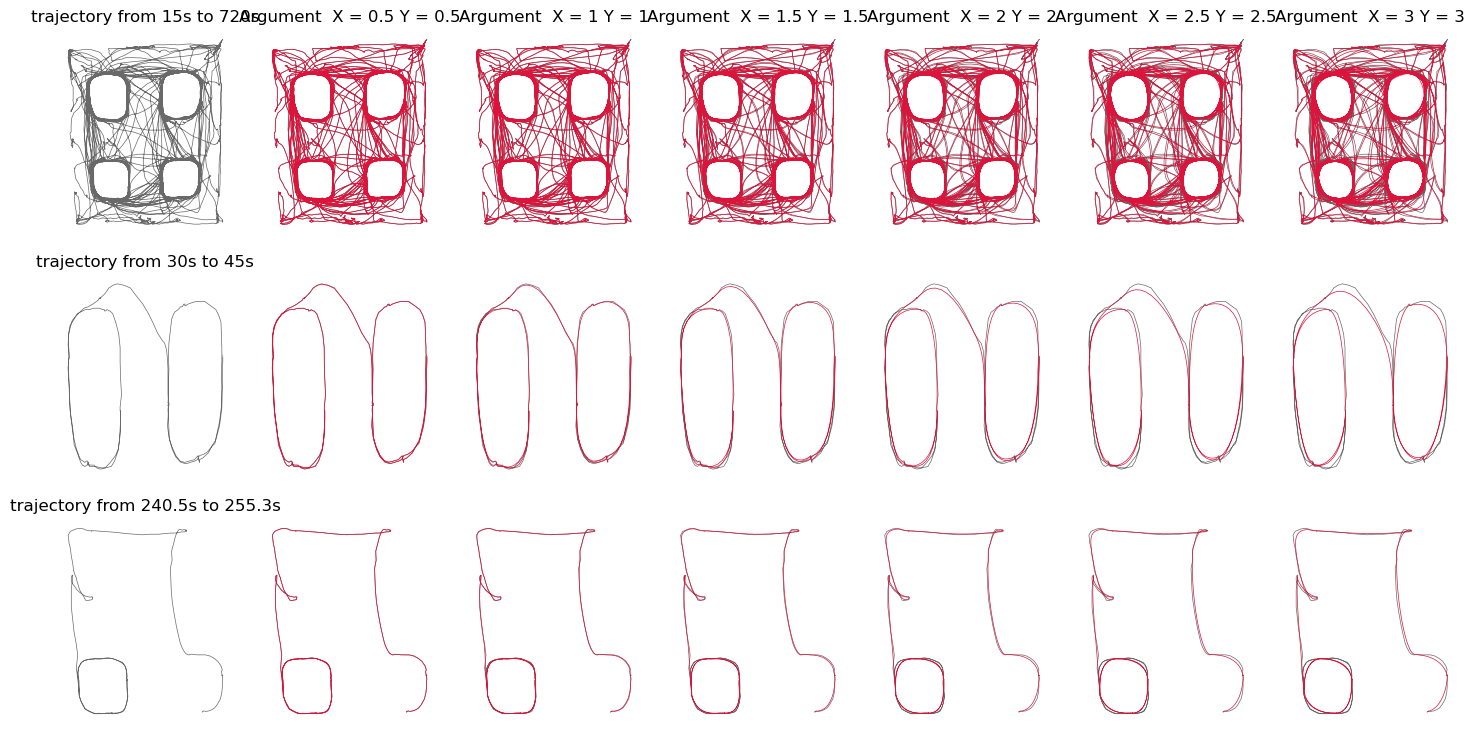

In [7]:
#creat a function which apply the smooth gaussian filter while having the format required for plot_whole_analysis
def function_gauss(position, epochs = [], sigma = 0): return smooth(position, sigma), epochs 

#for every small trajectory, show the effect of the smooth filter for every value of sigma in try_sigma_value
plot_whole_analysis( xdata= xposition, ydata= yposition, transformationX=function_gauss, transformationY = function_gauss, param1_x= try_sigma_value, 
                    param1_y= try_sigma_value, mirror= True, time_analysis= time_analysis, when_is_in_analysis= when_is_in_analysis, hide_axis= True,
                    colors= ['dimgray', 'crimson'], superimposed_original= True)

plot the speed across the time as well as the speed of try_cut_speed in relation

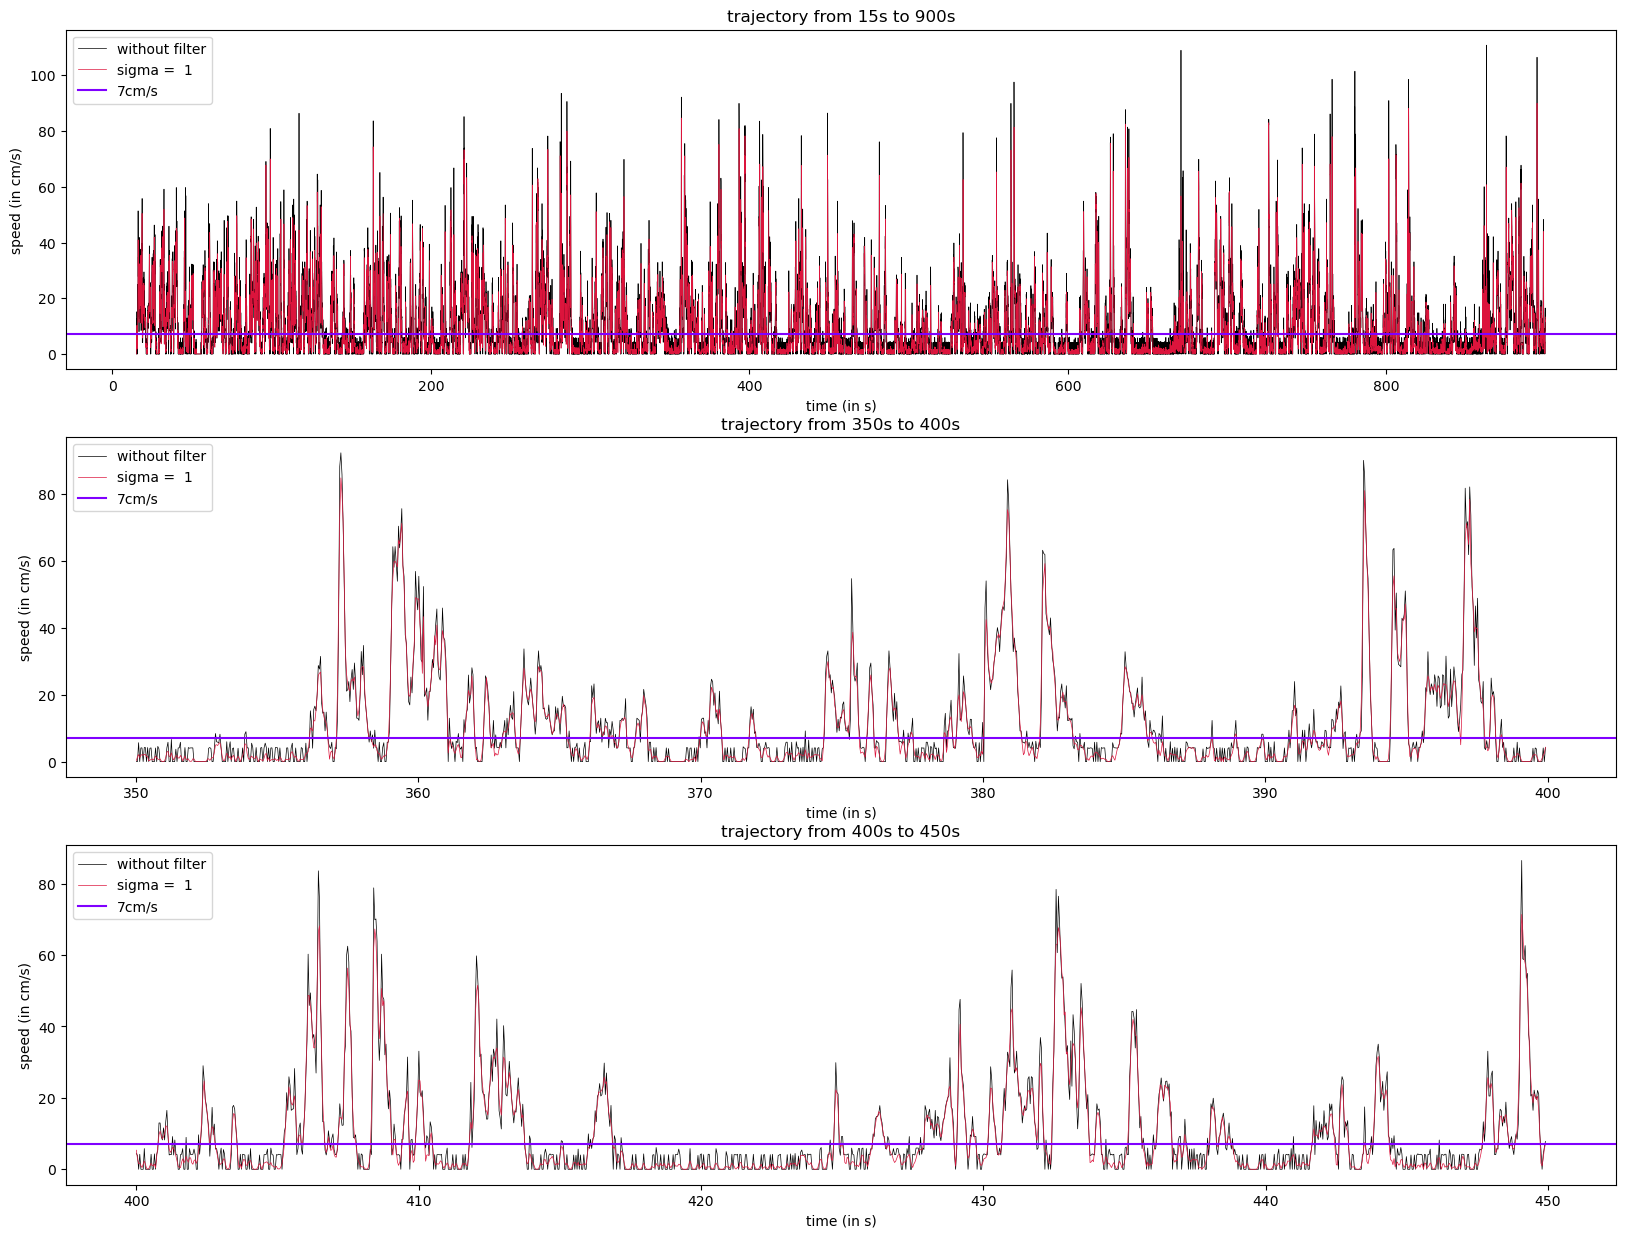

In [11]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(try_cut_speed)))#select a color for each element of try_cut_speed from the colormap rainbow

plt.figure(figsize= (20, 15)) #plot, for all small trajectory, the speed across time calculated from the raw datas compqred to the smoothened ones 
for a in range(0, number_of_analysis) : 
    plt.subplot(number_of_analysis,1,a + 1) 

    
    plt.plot(timeofframes[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], speeds_original[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], linewidth = 0.5, c = 'k', label = 'without filter')
    plt.plot(timeofframes[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], speeds_gauss[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], linewidth = 0.5, c = 'crimson', label = 'sigma =  ' + str(true_sigma))
    plt.title("trajectory from " + str(time_analysis[a][0]) + 's to ' + str(time_analysis[a][1]) + 's')
    plt.xlabel('time (in s)')
    plt.ylabel('speed (in cm/s)')
    for i in range(len(try_cut_speed)):
        plt.axhline( y = try_cut_speed[i], xmin= 0, xmax = 1, label = str(try_cut_speed[i]) + "cm/s", c = colors[i])
    plt.legend()
plt.show()

Speed filter : every point under a certain speed is discarded (problems with angular velocity). Because it causes artefacts, the first point of the movement is cut-off. Every epoch of a duration of under [MINIMAL_DURATION_EPOCH] is also discarded

551 epochs, argument = 7
14 epochs, argument = 7
17 epochs, argument = 7


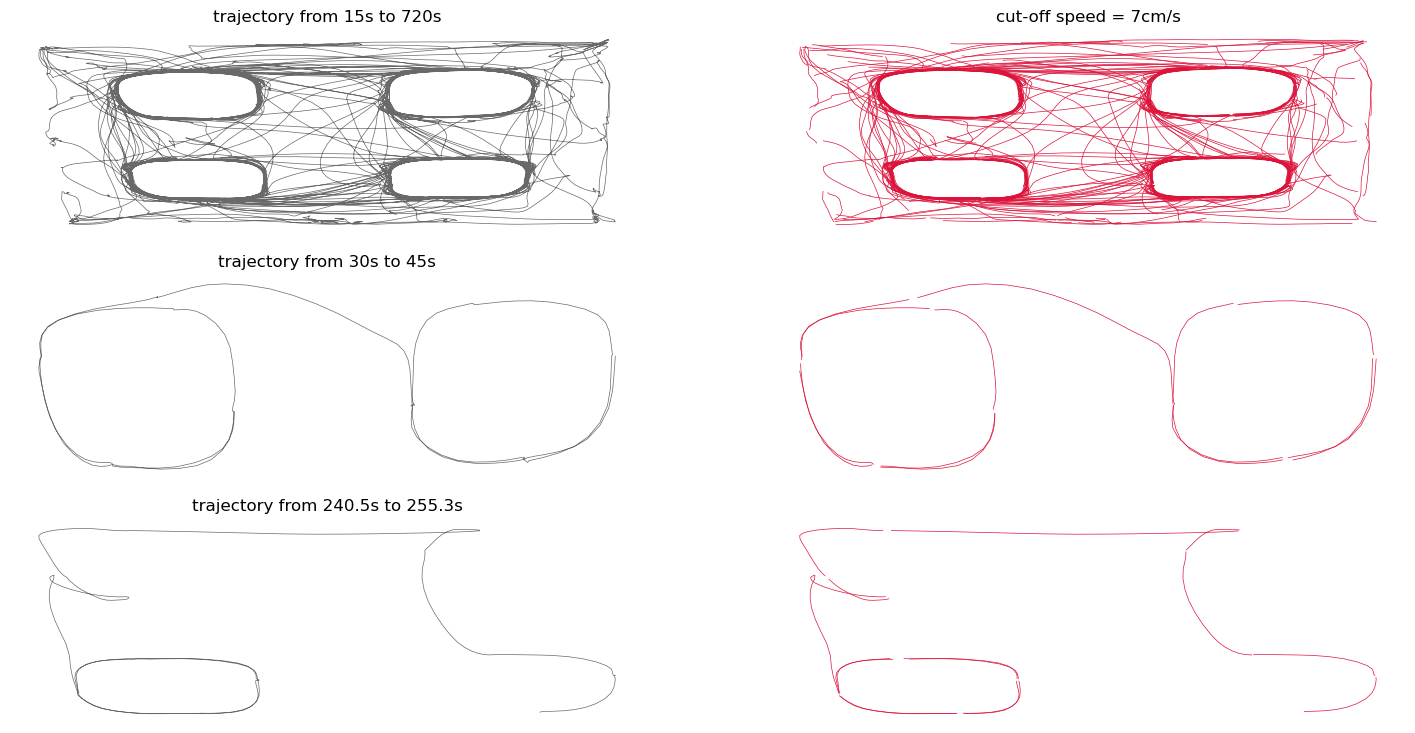

In [9]:

#plot the trajectory using different cut-off speed for the speed filter, with the smoothed position
plot_whole_analysis(xdata = xgauss, ydata = ygauss, param1_y= try_cut_speed, time_analysis=time_analysis, 
                    when_is_in_analysis = when_is_in_analysis, transformationY = cut_in_epoch_speed, param2_y = speeds_gauss, param3_y= time, 
                    in_epochs_after= True, hide_axis = True, colors=['dimgray', 'crimson'], argumentsName= "cut-off speed", argumentUnitY="cm/s")

Plot the orientation across the time  for diverse ecarts

551 epochs, argument = 1
14 epochs, argument = 1
17 epochs, argument = 1
551 epochs, argument = 2
14 epochs, argument = 2
17 epochs, argument = 2
551 epochs, argument = 3
14 epochs, argument = 3
17 epochs, argument = 3


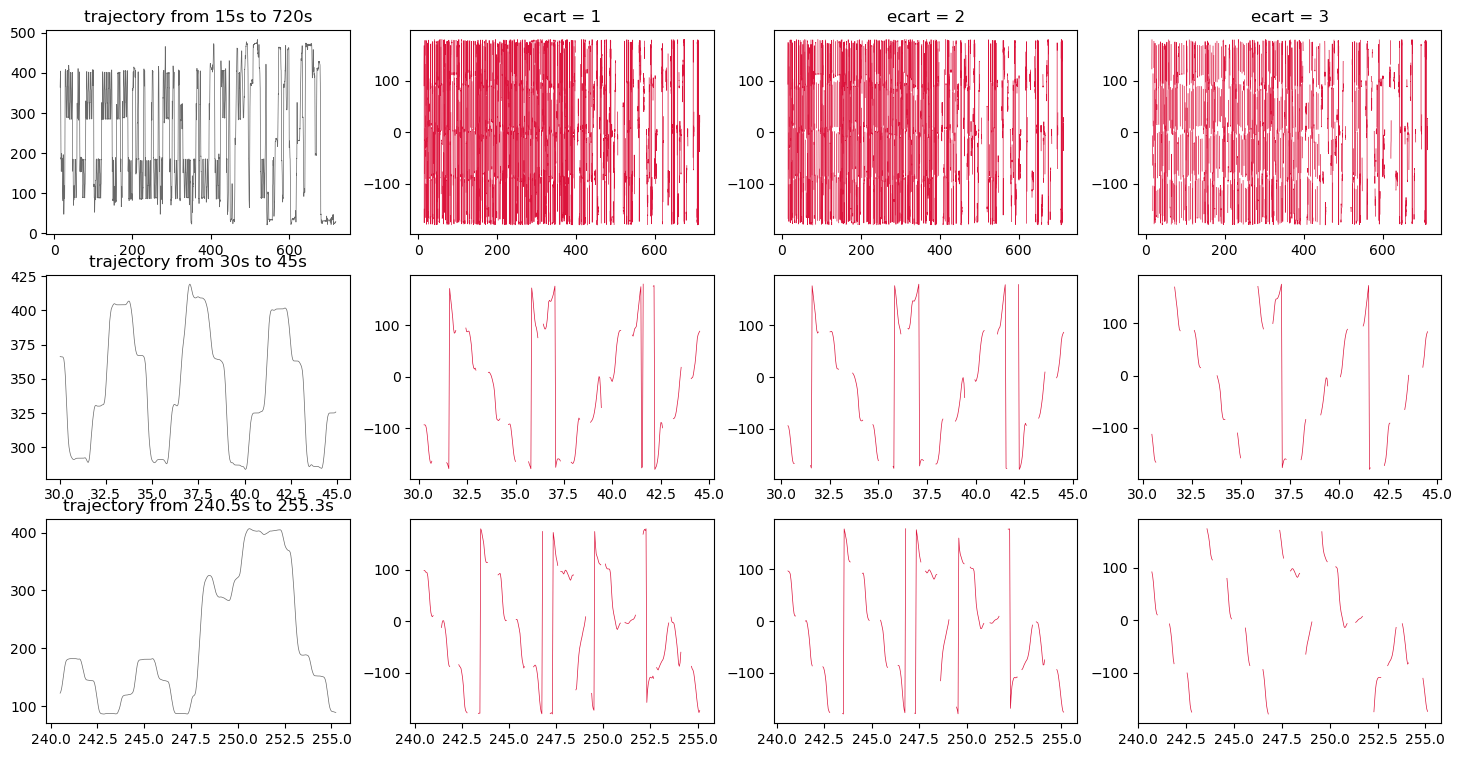

In [10]:
#show the orientation across time for every small trajectory and for different ecart used to calculate the orientation
plot_whole_analysis(xdata = time, ydata = ygauss, param1_y= try_ecart_angle, time_analysis=time_analysis, 
                    when_is_in_analysis = when_is_in_analysis, transformationY = calcul_angle, param2_y = xgauss, epochs= list_epochs,
                    in_epochs_after= True, colors=['dimgray', 'crimson'], argumentsName= "ecart")



plot the angular speed across the time using the ecart in try_ecart_angle

551 epochs, argument = 1
14 epochs, argument = 1
17 epochs, argument = 1
551 epochs, argument = 2
14 epochs, argument = 2
17 epochs, argument = 2
551 epochs, argument = 3
14 epochs, argument = 3
17 epochs, argument = 3


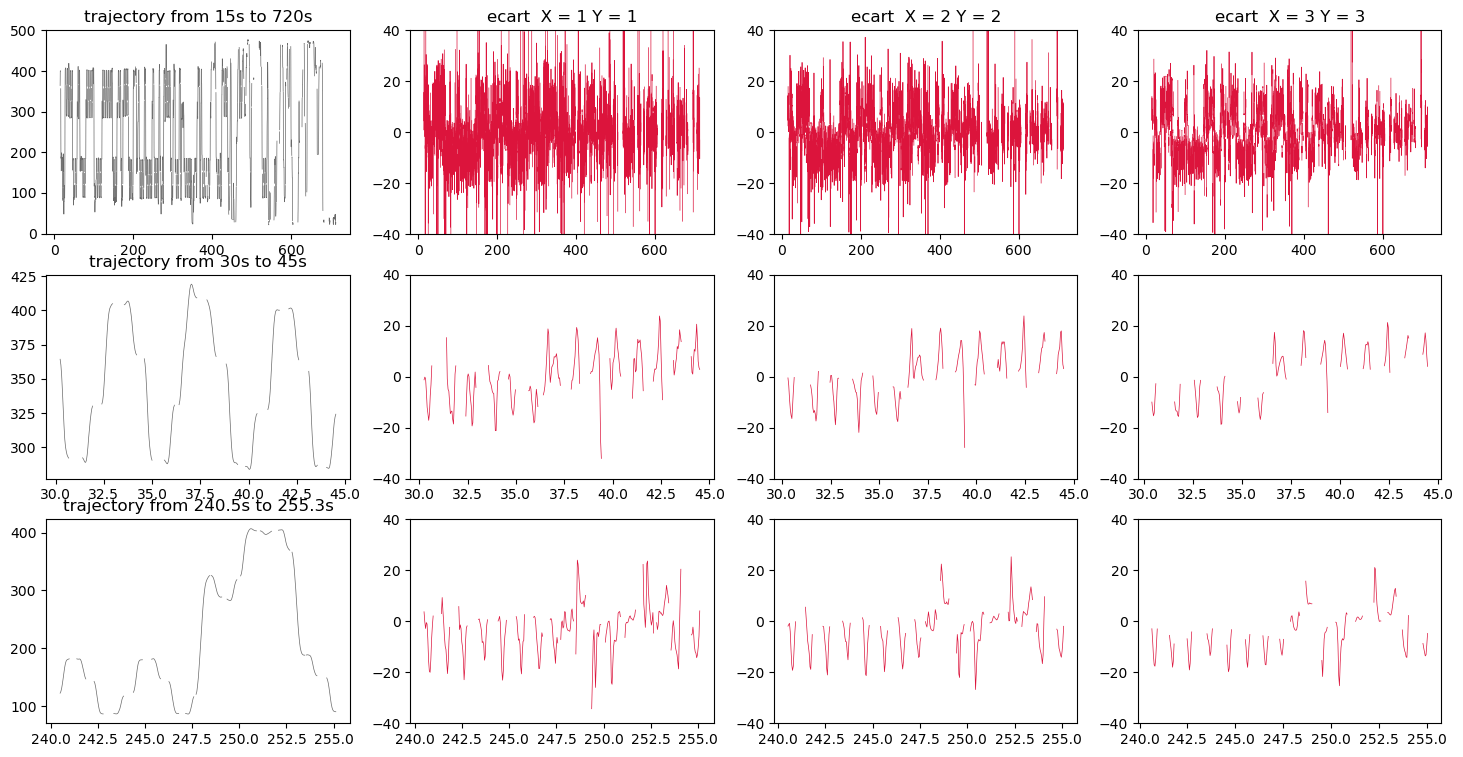

In [11]:
#plot angular speed for the small trajectory using different ecart to calculate the orientation.
plot_whole_analysis(xdata = time, ydata = ygauss, time_analysis=time_analysis, when_is_in_analysis=when_is_in_analysis, transformationX= get_time_average,
                     transformationY= calcul_angular_speed, param1_x= try_ecart_angle, param1_y= try_ecart_angle, param2_y= xgauss, param3_y=time, mirror=True,
                     in_epochs_before= True, in_epochs_after= True, epochs = list_epochs, colors=['dimgray', 'crimson'], argumentsName= "ecart", ylimit=(-40, 40))

Show the orientation during the epochs

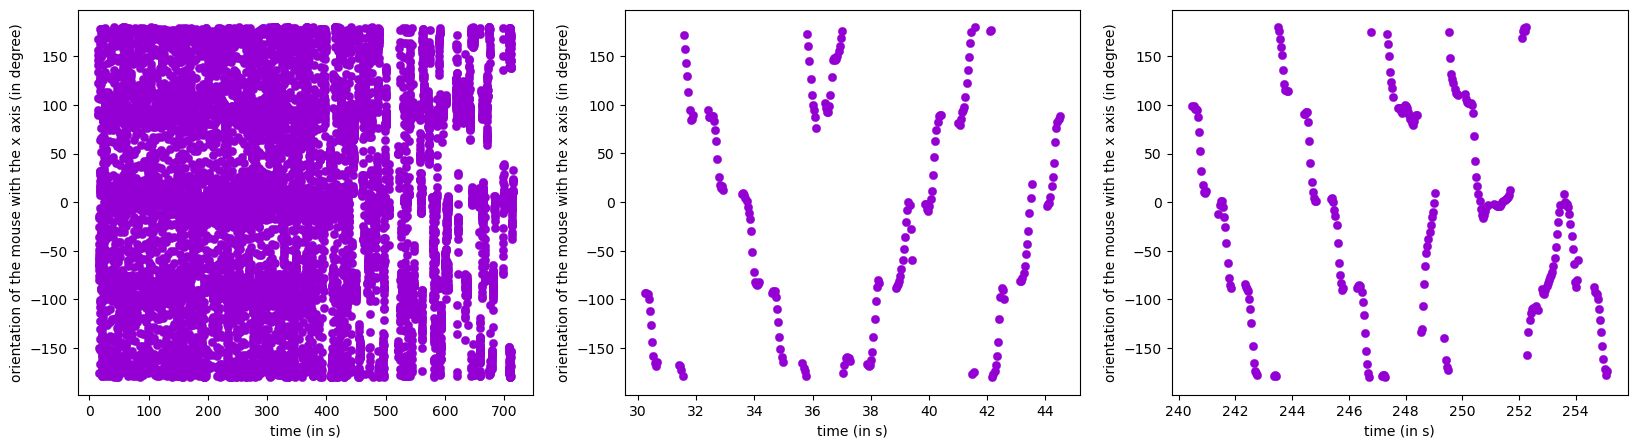

In [12]:


#plot the orientation of the mouse for the small trajectory when it is in an epoch
plt.figure(figsize = (20, 5)) 
for a in range(number_of_analysis):
    plt.subplot( 1, len(time_analysis), a+1)#select the subplot
    smaller_epochs = get_epoch_small_analysis(epochs = list_epochs_angle, when_is_in_analysis= when_is_in_analysis[a])#get the epochs concerned for the small trajectory
    for i in range(len(smaller_epochs)) :#print the epochs of the small trajectory
        plt.scatter(time_average[smaller_epochs[i][0] : smaller_epochs[i][1]],angles[smaller_epochs[i][0] : smaller_epochs[i][1]], c= 'darkviolet', linewidths= 0.3)#print the epochs one by one, using timeofframes to not 

    plt.xlabel('time (in s)')
    plt.ylabel('orientation of the mouse with the x axis (in degree)')
plt.show()

show the orientation of the mouse inculding outside epochs

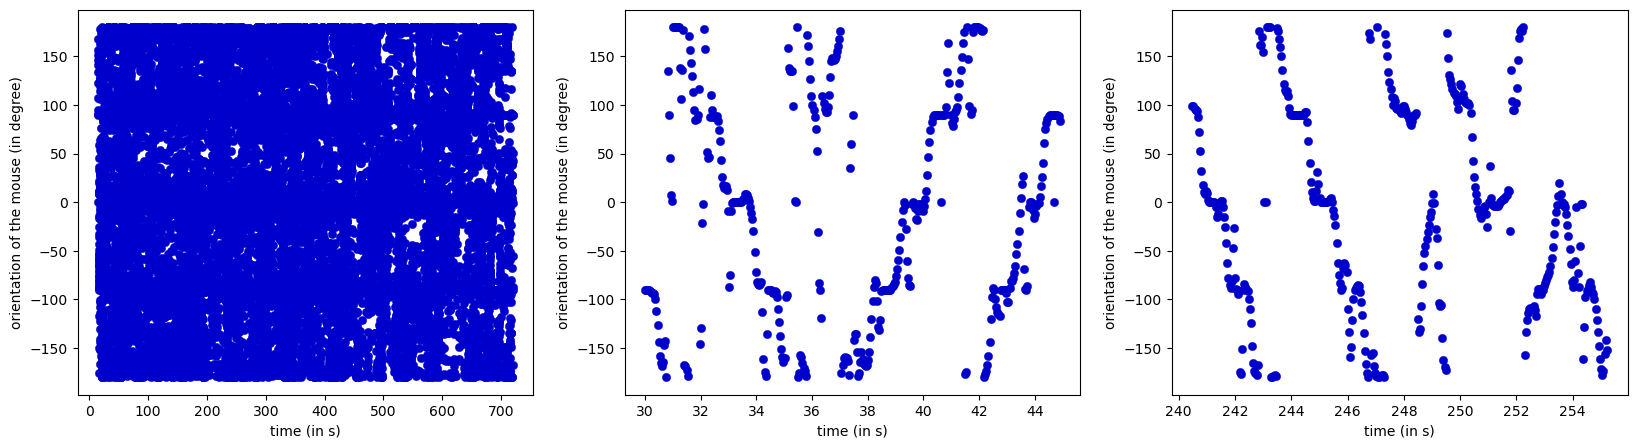

In [13]:
plt.figure(figsize = (20, 5)) #print the orientations for the whole small trajectory, without limiting to the epochs
for a in range( number_of_analysis):
    plt.subplot( 1, number_of_analysis, a+1)
    plt.scatter(time_average[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]],angles[when_is_in_analysis[a][0] : when_is_in_analysis[a][1]], c= 'mediumblue', linewidths= 0.3)#print the epochs one by one, using timeofframes to not 

    plt.xlabel('time (in s)')
    plt.ylabel('orientation of the mouse (in degree)')
plt.show()



plot the angular speed

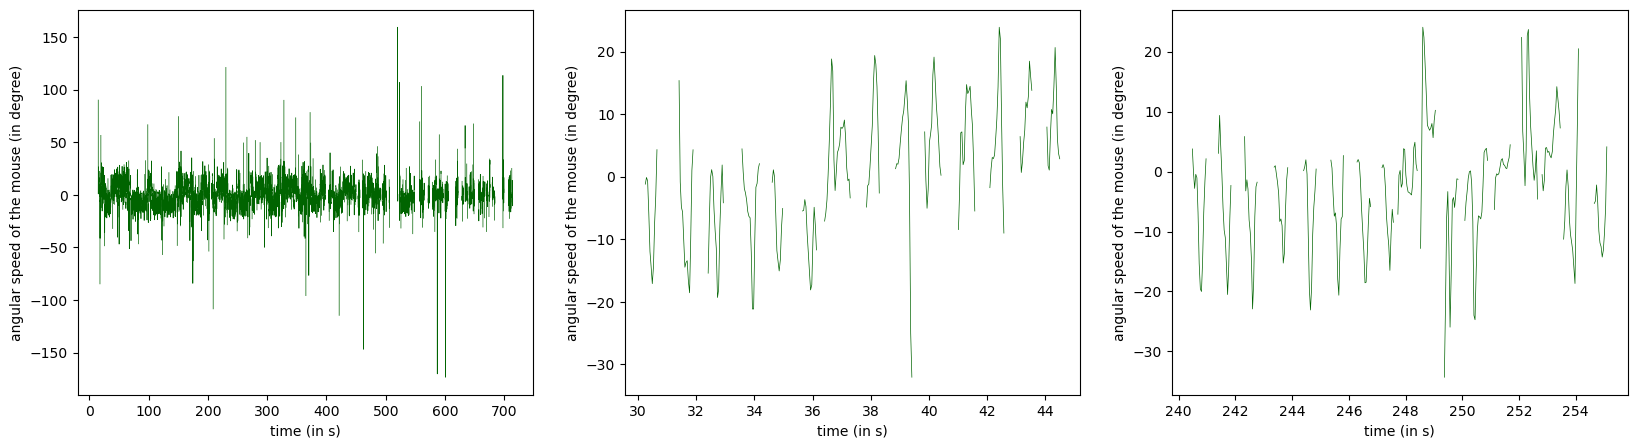

In [14]:


plt.figure( figsize = (20, 5))
for a in range(number_of_analysis):
    plt.subplot(1, number_of_analysis, a+1)
    smaller_epochs = get_epoch_small_analysis(epochs= list_epochs_angle, when_is_in_analysis= when_is_in_analysis[a])
    for i in range(len(smaller_epochs)) :
        plt.plot(time_average[smaller_epochs[i][0] : smaller_epochs[i][1]], angular_speed[smaller_epochs[i][0] : smaller_epochs[i][1]], linewidth = 0.5, c = "darkgreen")
    plt.xlabel('time (in s)')
    plt.ylabel('angular speed of the mouse (in degree)')
plt.show()


is used to see the trajectory during qn epoch and the detection trapeze

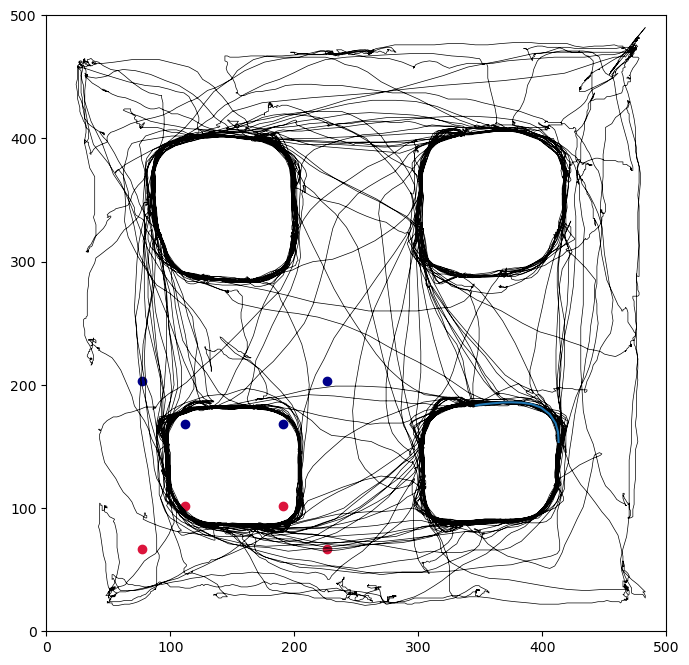

In [15]:
#sert a afficher un virage et les trapeze concernes
plt.figure(figsize=(8,8))
epoch = list_epochs[56]
plt.plot(xposition[when_is_in_analysis[0][0] : when_is_in_analysis[0][1]], yposition[when_is_in_analysis[0][0] : when_is_in_analysis[0][1]], linewidth= 0.5, c= 'k') #when_is_in_analysis is used to know the indices of the axis 
for trapeze in collection_trapeze["SW"]["S"]:
    plt.scatter(trapeze[0], trapeze[1], c = 'crimson')
for trapeze in collection_trapeze["SW"]["N"]:
   plt.scatter(trapeze[0], trapeze[1], c = 'darkblue')
plt.plot(xgauss[epoch[0] : epoch[1]], ygauss[epoch[0] : epoch[1]])
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

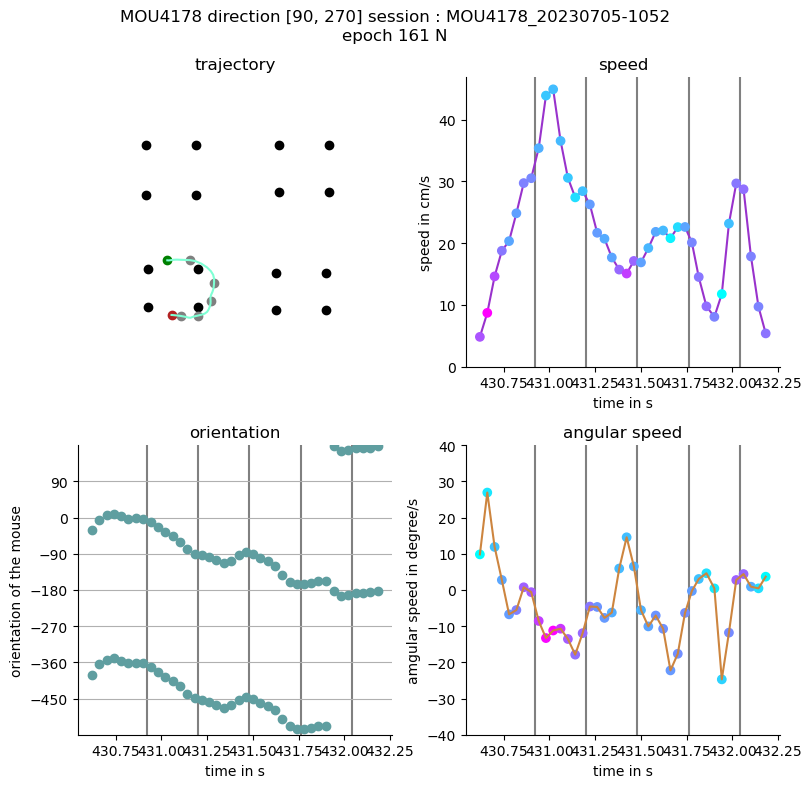

In [23]:
#show an analysis of a given epoch
#the color of the dots in angular speed represent the moving speed

show_epoch(161, xgauss, ygauss, speeds_gauss, angular_speed, angles, time, list_epochs, timeofframes, time_average, mouseName, session, session_direction)

Show an analysis of the whole trajectory

1.299938382254089


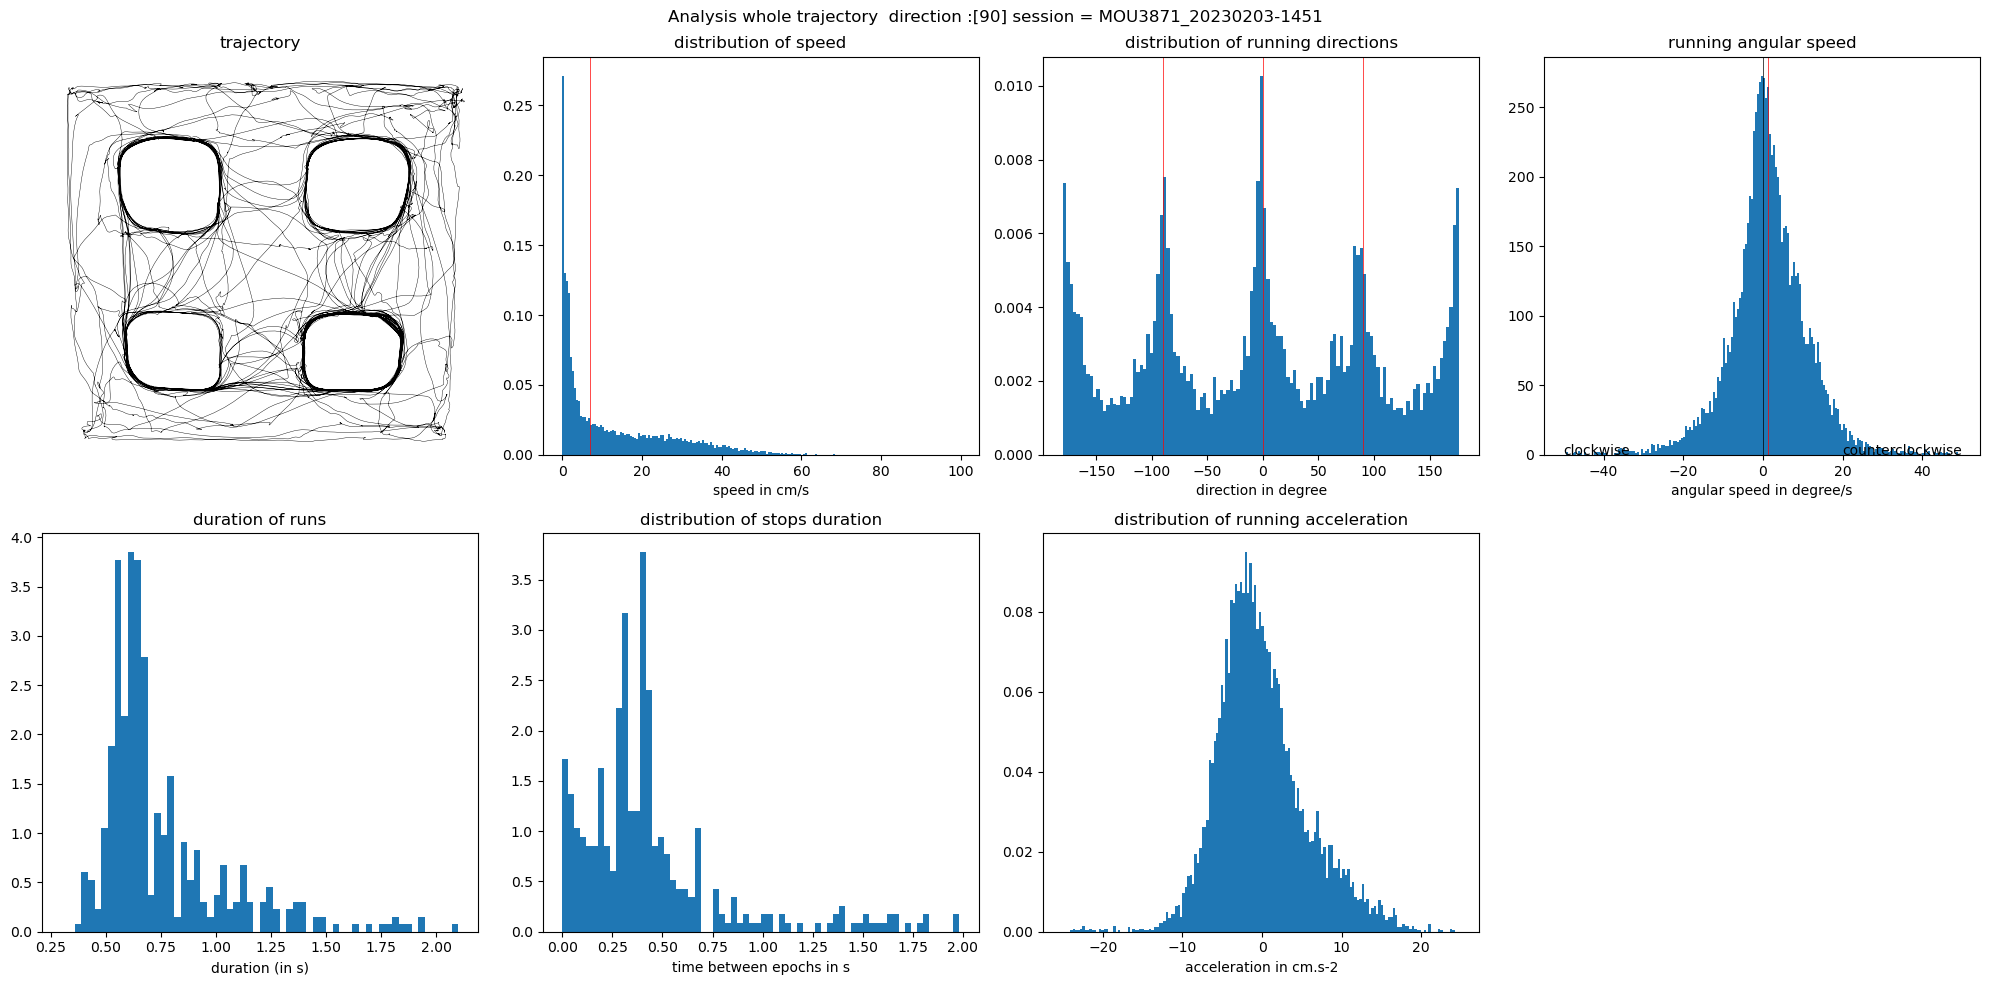

In [9]:
#show an analysis of the trajectory

orientation_in_movement = []#keep only the orientation during the epochs
angular_speed_in_movement = []# ---------- angular speed -------------
acceleration_in_movement = []# ---------- acceleration -------------
for a in list_epochs_angle :
    for i in range(a[0], a[1] + 1) :
        orientation_in_movement += [angles[i]]
        angular_speed_in_movement += [angular_speed[i]]
        acceleration_in_movement += [acceleration[i]]


plt.figure(figsize = (20, 10))
plt.subplot(2, 4, 1)#plot the trajectory
plt.plot(xgauss, ygauss, c= "k", linewidth = 0.3); plt.xlim(0,500);plt.ylim(0,500); plt.axis('off'); plt.title("trajectory")

plt.subplot(2, 4, 2)#plot the distribution of speed
plt.hist(speeds_gauss, bins = np.arange(0, 100, 0.5), density = True)
plt.xlabel("speed in cm/s")
plt.title('distribution of speed')
plt.axvline(true_cut_speed, c = 'red', linewidth = 0.5)

plt.subplot(2, 4, 3)#plot the distribution of direction
plt.hist(orientation_in_movement, bins = np.arange(-180, 180, 3), density = True)
plt.xlabel("direction in degree")
plt.title('distribution of running directions') 
plt.axvline(0, c = 'red', linewidth = 0.5) ; plt.axvline(-90, c = 'red', linewidth = 0.5) ; plt.axvline(90, c = 'red', linewidth = 0.5)


plt.subplot(2, 4, 4) # plot the distribution of angular speed

data_histo = plt.hist(angular_speed_in_movement, bins = np.arange(-50, 50, .5), density = False)
mean_bin =  [(data_histo[1][i] + data_histo[1][i - 1]) / 2 for i in range(1, len(data_histo[1]))] + [(3 * data_histo[1][-1]  - data_histo[1][-2]) / 2]
value_per_bin = [data_histo[0][i] * mean_bin[i] for i in range(len(data_histo[0]))]
plt.xlabel("angular speed in degree/s")
plt.title('running angular speed')
plt.text(-50, 0.02, "clockwise", ha = 'left') ; plt.text(50, 0.02, "counterclockwise", ha = 'right')
plt.axvline(np.sum(value_per_bin) / len(angular_speed_in_movement), c = 'red', linewidth = 0.5) ; plt.axvline(0, c= 'k', linewidth = 0.5)
print(np.sum(value_per_bin) / len(angular_speed_in_movement))

plt.subplot(2, 4, 5) #show the repartition of epochs times
duration_of_epochs = [time_average[epochs[1]] - time_average[epochs[0]] for epochs in list_epochs]#compute the time between the beginning and the end of an epoch
plt.hist(duration_of_epochs, bins = np.arange(MINIMAL_DURATION_EPOCH, 2.1, .03), density = True, )
plt.xlabel("duration (in s)")
plt.title('duration of runs')

plt.subplot(2, 4, 6) #show the repartition of pauses times
#compute the time between the beginning of an epoch and the end of the previous epoch
duration_of_stops = [time_average[stop[1]] - time_average[stop[0]] for stop in list_of_stops]
plt.hist(duration_of_stops, bins = np.arange(0, 2, 0.03), density = True)
plt.xlabel("time between epochs in s")
plt.title('distribution of stops duration')

plt.subplot(2, 4, 7)#plot the distribution of direction
plt.hist(acceleration_in_movement, bins = np.arange(-25, 25, 0.3), density = True)
plt.xlabel("acceleration in cm.s-2")
plt.title('distribution of running acceleration') 


plt.suptitle("Analysis whole trajectory  direction :" + session_direction + " session = " + session)
plt.tight_layout()
plt.show()


show the quarter turn, the ither movement and the stops, as well as the heatmap of the position in these cases

3.6809675141242937


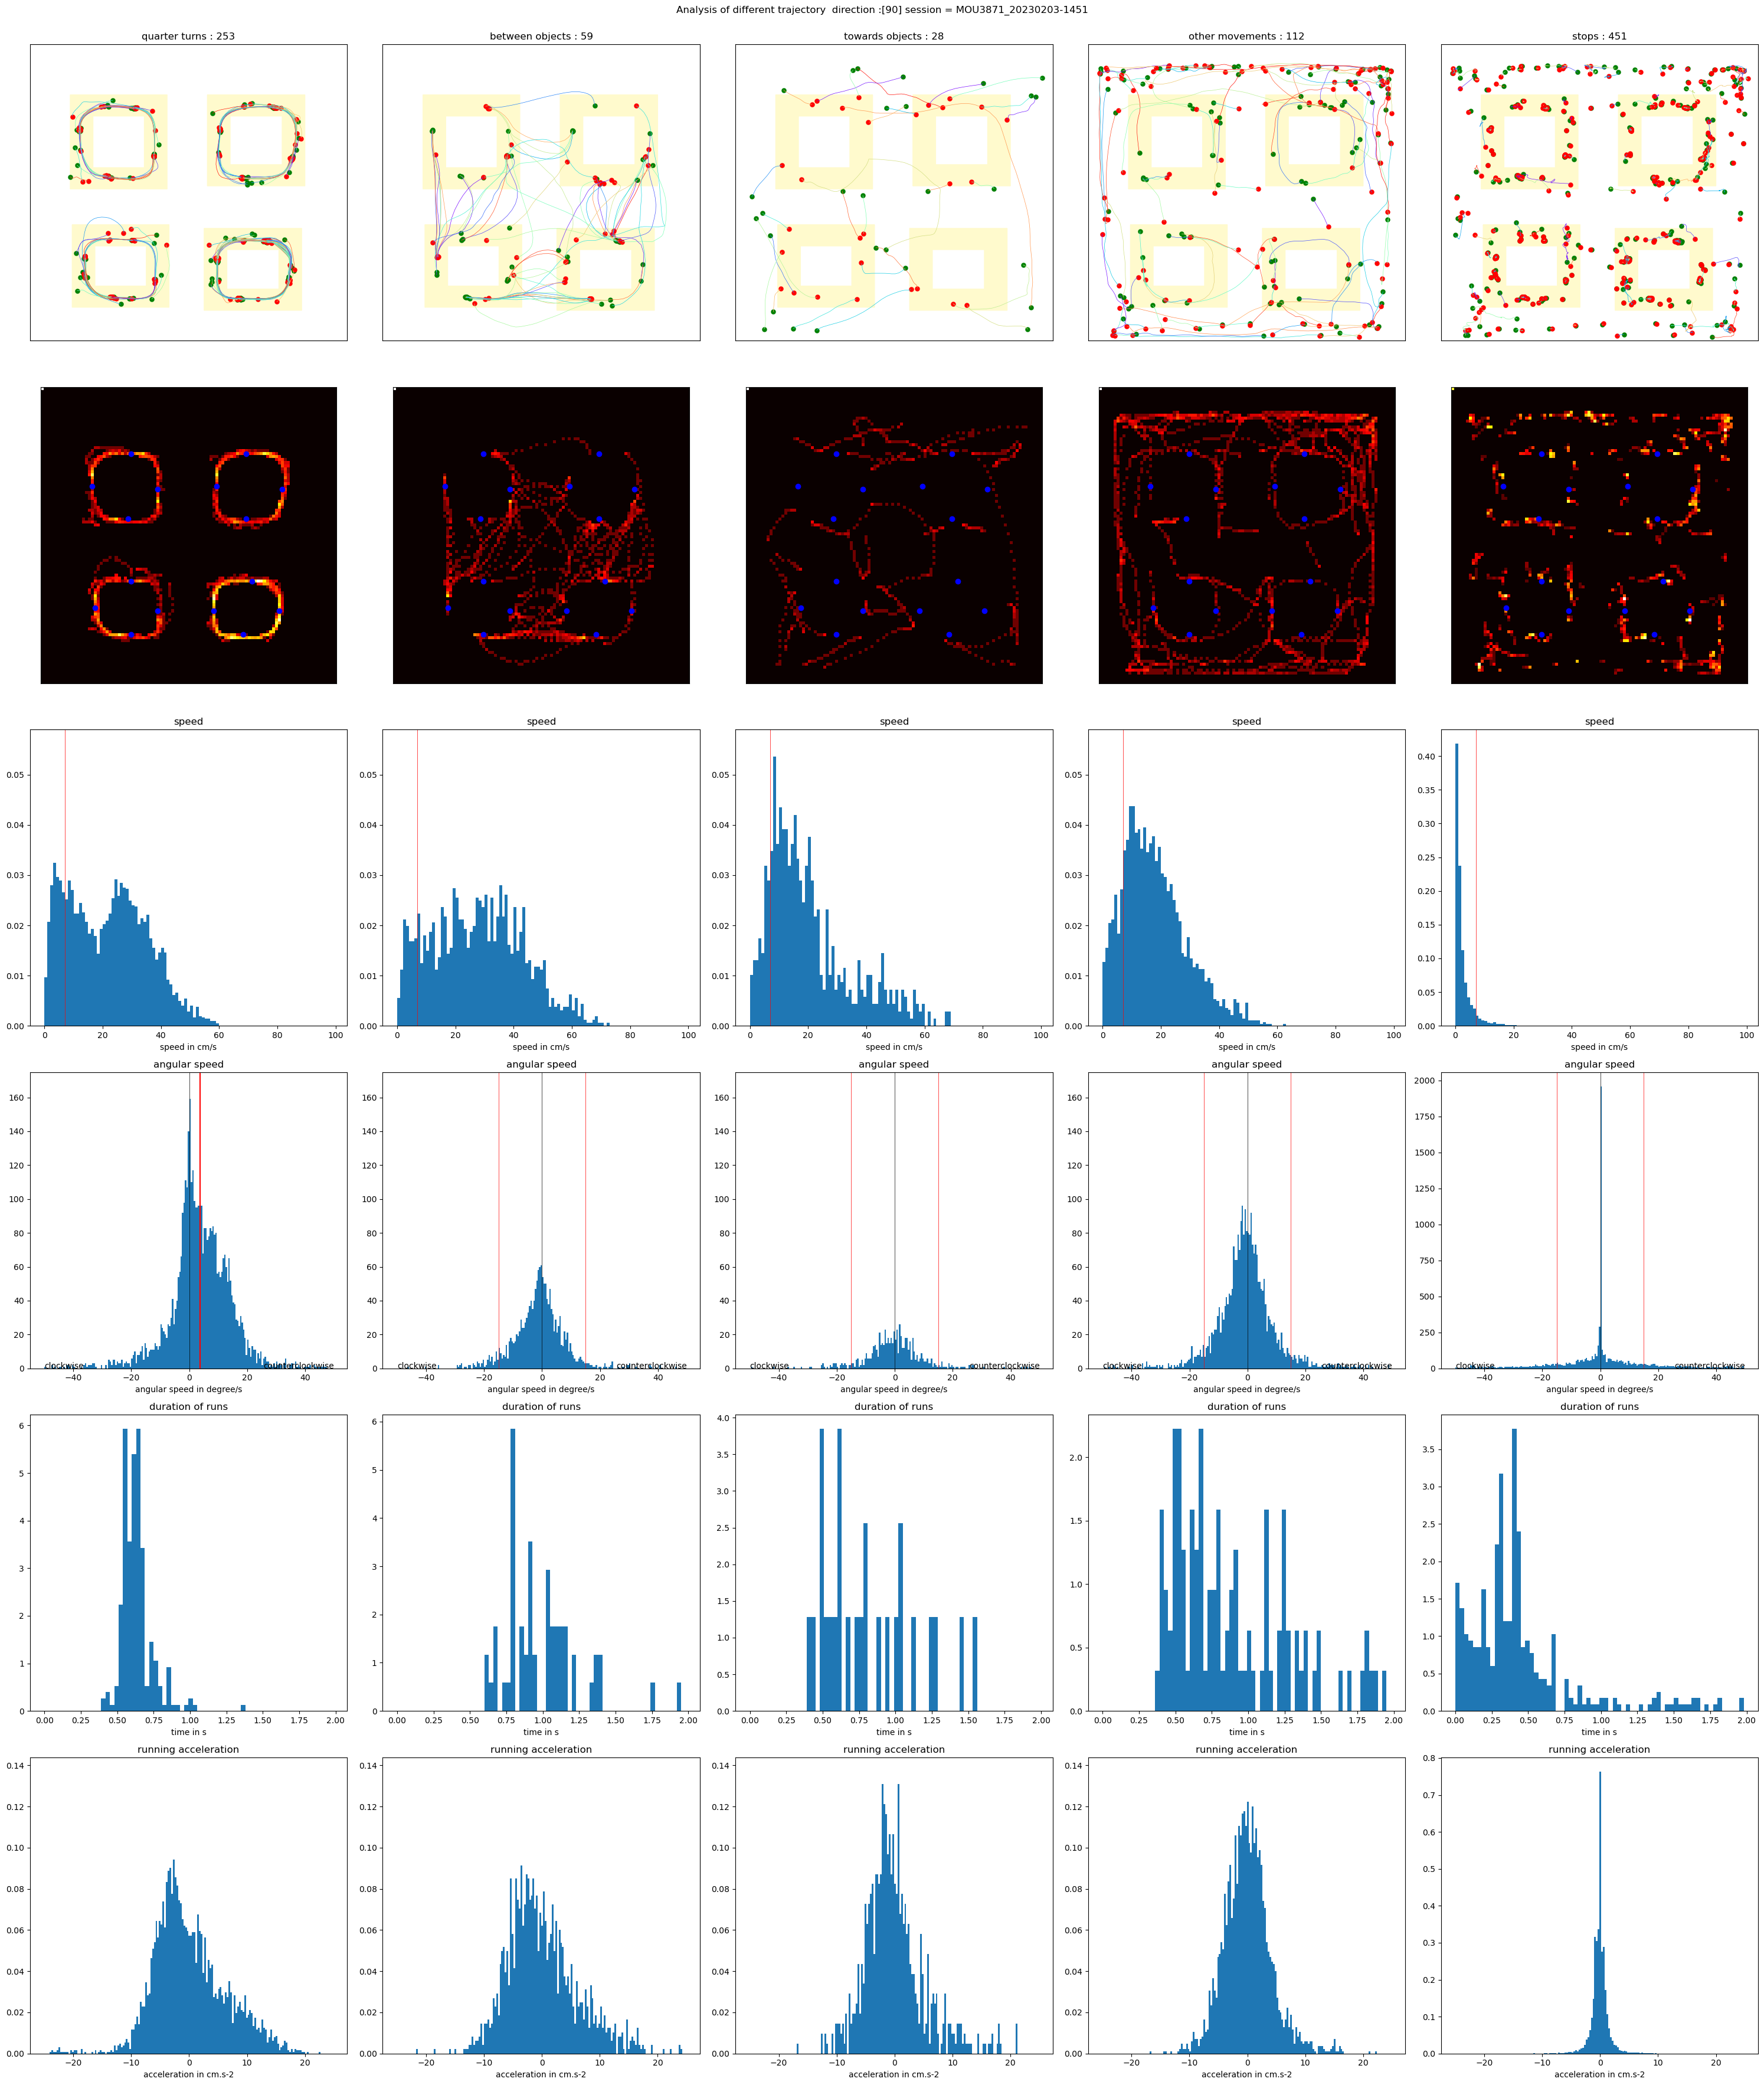

In [14]:


nb_column = 5 #one for each type of trajectory
nb_line = 6 #one for each graph to be plotted

maps_union = [np.zeros((100, 100)), np.zeros((100, 100)), np.zeros((100, 100)), np.zeros((100, 100)), np.zeros((100, 100))]

for a in range(nb_column):
    for i in [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a] :
        for u in range(i[0], i[1] + 1) :
            maps_union[a][  int((Resolution[1] - ygauss[u]) *100 /Resolution[1]), int(xgauss[u] * 100 /Resolution[0]) ] +=1 #for each position of the mouse add  one to the corresponding entry in the grid
        
maps_union[0][0,0] = maps_union[1][0, 0] = maps_union[2][0,0] = maps_union[3][0,0] = maps_union[4][0,0] = max( np.max(maps_union[0]), np.max(maps_union[1]), np.max(maps_union[2]))#set a maximum for all maps
maps_union[0][1,0] = maps_union[1][1, 0] = maps_union[2][1,0] = maps_union[3][1,0] = maps_union[4][1,0] = 0 #set the adjacent pixel as a minimum for all maps
maps_union[0] = np.log(maps_union[0] + 1); maps_union[1] = np.log(maps_union[1] + 1) ; maps_union[2] = np.log(maps_union[2] + 1); maps_union[3] = np.log(maps_union[3] + 1); maps_union[4] = np.log(maps_union[4] + 1)#take the log of the graph to keep them readable

max_height_speed = []
max_height_angular = []
max_height_accel = []


fig = plt.figure(figsize = (6 * nb_column, 6 * nb_line))
fig.suptitle("Analysis of different trajectory  direction :" + session_direction + " session = " + session + '\n\n')
for a in range(nb_column):

    #plot the trajectory of the current mod
    ax  = fig.add_subplot(nb_line, nb_column, 1 + a)

    
    for patch in collection_trapeze :#plot the trapeze around the object
        for trapeze in collection_trapeze[patch] :
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color = "lemonchiffon")
            # plt.gca().add_patch(shape)
            ax.add_patch(shape)

    for u in [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a] :#plot each individual trajectory of the current category
        colors = plt.cm.rainbow(np.random.random())
        ax.plot( xgauss[u[0] : u[1]], ygauss[u[0] : u[1]], linewidth = 0.5, c = colors )
    indices_start = [u[0] for u in [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a]]
    indices_end = [u[1] for u in [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a]]
    ax.scatter(xgauss[indices_start], ygauss[indices_start], linewidths= 0.1, color = "green")
    ax.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color = "red")
    ax.set_title(["quarter turns : ", "between objects : ", "towards objects : ", "other movements : ", "stops : "][a] + str(len([list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a]))); plt.xlim(12, 500); plt.ylim(12, 500)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    #plot the heatmap of the position occupied in the quarter turns

    ax1 = fig.add_subplot(nb_line, nb_column, nb_column + 1 + a)


    ax1.imshow(maps_union[a], cmap='hot', interpolation='nearest')
    ax1.scatter([int(waterports[i][1] * 100 / Resolution[0]) for i in waterports],[int(waterports[i][0] * 100 / Resolution[0]) for i in waterports], c= "blue")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)



    #get all the speed and angular speed of the category
    speedy = [] ; angle_speedy = []; accelery = []
    for u in [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a] :
        for i in range(u[0], u[1] + 1) :
            speedy += [speeds_gauss[i]]
            angle_speedy += [angular_speed[i]]
            accelery += [acceleration[i]]
    

    #plot the distribution of speed
    ax2 = fig.add_subplot(nb_line, nb_column, 2* nb_column +1 +a )
    values, _ , _ = ax2.hist(speedy, bins = np.arange(0, 100, 1), density = True)
    max_height_speed.append( max(values) )
    ax2.set_xlabel("speed in cm/s")
    ax2.set_title('speed')
    ax2.axvline(true_cut_speed, c = 'red', linewidth = 0.5)


    #plot the angular speed for the type of trajectory
    ax3 = fig.add_subplot(nb_line, nb_column, 3* nb_column +1 +a )
    values, binette , _ = ax3.hist(angle_speedy, bins = np.arange(-50, 50, .5), density = False)
    max_height_angular.append( max(values) )
    ax3.set_xlabel("angular speed in degree/s")
    ax3.text(-50, 0.02, "clockwise", ha = 'left') ; plt.text(50, 0.02, "counterclockwise", ha = 'right')
    ax3.set_title('angular speed')
    #ax3.set_ylim(0, [0.07, 0.083, 0.18, 0.11, 0.55][a])
    if a == 0 :
        mean_bin =  [(binette[i] + binette[i - 1]) / 2 for i in range(1, len(binette))] + [(3 * binette[-1]  - binette[-2]) / 2]
        value_per_bin = [values[i] * mean_bin[i] for i in range(len(values))]
        plt.axvline(np.sum(value_per_bin) / len(angle_speedy), c = 'red') ; plt.axvline(0, c= 'k', linewidth = 0.5)
        print(np.sum(value_per_bin) / len(angle_speedy))

    else : 
        ax3.axvline(15, c = 'red', linewidth = 0.5) ; plt.axvline(-15, c = 'red', linewidth = 0.5) ; plt.axvline(0, c= 'k', linewidth = 0.5)


    #plot the distribution of trajectory length
    ax4 = fig.add_subplot(nb_line, nb_column, 4* nb_column +1 +a )
    current_list = [list_quarter_turn, list_between_object, list_toward_object, list_movement_not_quarter, list_of_stops][a]
    ax4.hist([(time_average[u[1]] - time_average[u[0]]) for u in current_list], bins = np.arange(0, 2, 0.03), density= True)
    ax4.set_title("duration of runs")
    ax4.set_xlabel("time in s")


    ax5 = fig.add_subplot(nb_line, nb_column, 5* nb_column +1 +a ) #plot the acceleration
    values, _ , _ = ax5.hist(accelery, bins = np.arange(-25, 25, 0.3), density = True)
    max_height_accel.append( max(values))
    ax5.set_xlabel('acceleration in cm.s-2')
    ax5.set_title('running acceleration')

max_height_speed.sort()
max_height_angular.sort()
max_height_accel.sort()

for a in range(4) :
    plt.subplot(nb_line, nb_column, 2* nb_column +1 +a )
    plt.ylim(0, max_height_speed[-2] + 0.1* max_height_speed[-2])#it's sorted in increasing order, and we want to ignore the stops, so the maximum we want is the second to last

    plt.subplot(nb_line, nb_column, 3* nb_column +1 +a )
    plt.ylim(0, max_height_angular[-2] + 0.1* max_height_angular[-2])

    plt.subplot(nb_line, nb_column, 5* nb_column +1 +a ) 
    plt.ylim(0, max_height_accel[-2] + 0.1* max_height_accel[-2])

plt.tight_layout(rect=(0,0, 1, 0.99))

show difference between clokwise quarter-turn and counter-clokwise quarter turn

32 clockwise turns
221 anti-clockwise turns


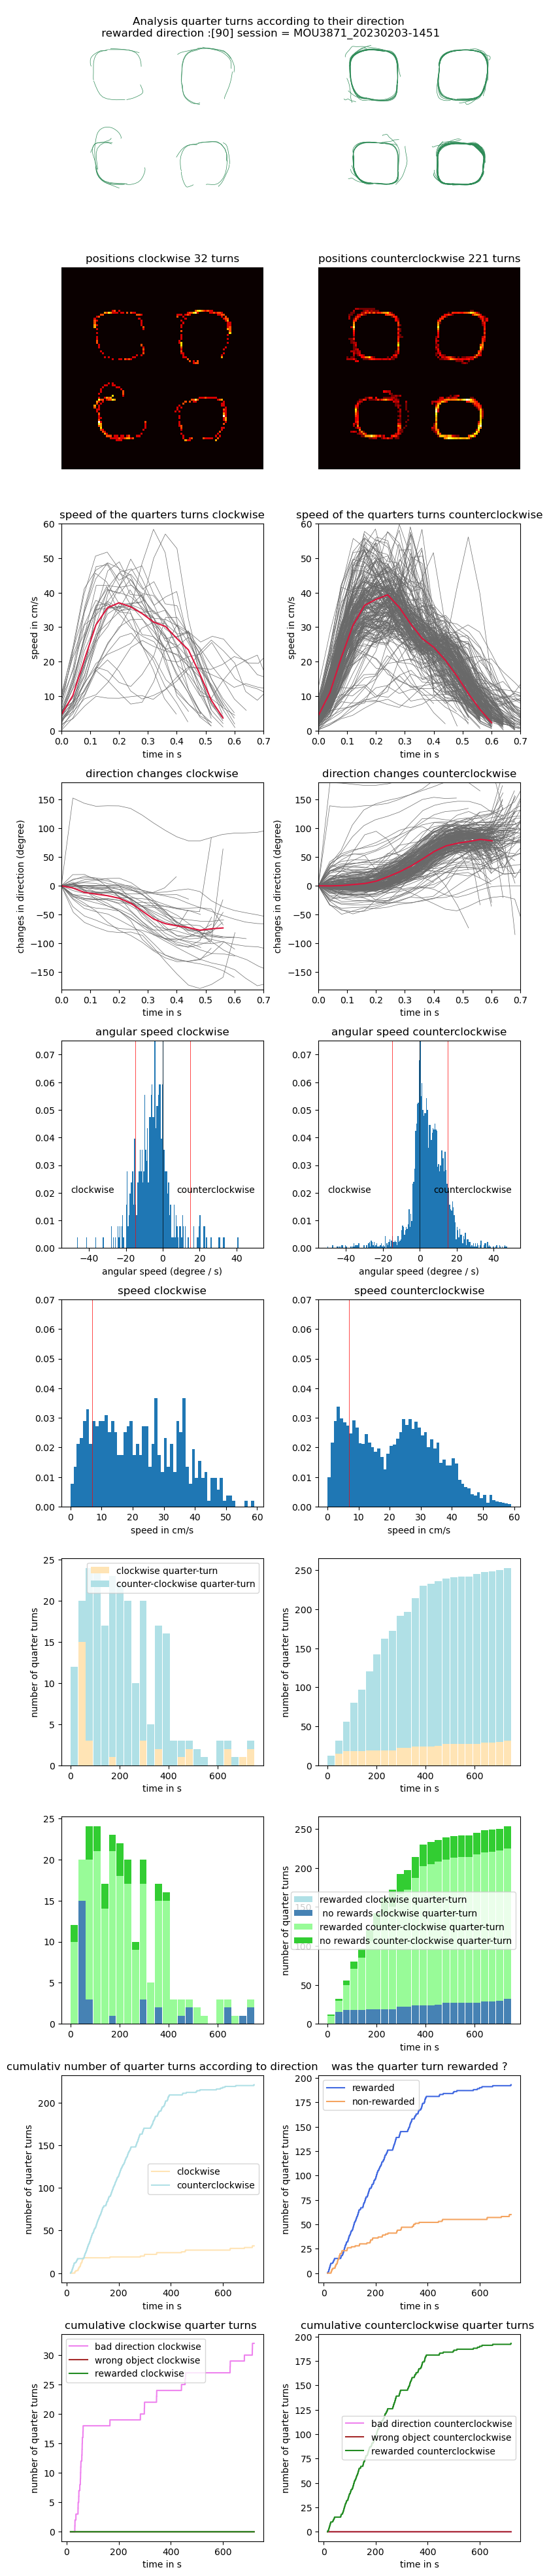

In [36]:


print(str(len(clock_turn["total"])) + " clockwise turns\n"  + str(len(anti_clock_turn["total"])) + " anti-clockwise turns")

nb_line = 10 ; nb_column = 2
plt.figure( figsize= (8,4 * nb_line))
plt.suptitle("Analysis quarter turns according to their direction\n rewarded direction :" + session_direction + " session = " + session)
for a in range (nb_column):
    direction = ["clockwise" , "counterclockwise"][a]


    plt.subplot(nb_line, nb_column, 1 + a)#plot the qurter turns
    for u in [clock_turn["total"], anti_clock_turn["total"]][a] :
        plt.plot( xgauss[u[0] : u[1] + 1], ygauss[u[0] : u[1] + 1], linewidth = 0.5, c = "seagreen" )
    #plt.title(["clockwise", "anti-clockwise"][a]) #takken of because problem of placement
    plt.xlim(12, 500); plt.ylim(12, 500)
    plt.axis("off")

    #########
    plt.subplot(nb_line, nb_column, nb_column + 1 + a)#plot the heatmap of the position occupied in the quarter turns
    map_positions = np.zeros((100, 100))
    for i in [clock_turn["total"], anti_clock_turn["total"]][a] :
        for u in range(i[0], i[1] + 1) :
            map_positions[  int((512 - ygauss[u]) *100 /512), int(xgauss[u] * 100 /512) ] +=1
    map_positions = np.log(map_positions +1)
    plt.imshow(map_positions, cmap='hot', interpolation='nearest')
    plt.axis("off"); plt.title("positions " + direction + " " + str(len([clock_turn["total"], anti_clock_turn["total"]][a])) + " turns")

    ########
    plt.subplot(nb_line, nb_column, nb_column*2 + 1 +a)#plot the indidual speed profile of every quarter turn
    for u in [clock_turn["total"], anti_clock_turn["total"]][a] :
        plt.plot(timeofframes[u[0] : u[1] + 1]  - timeofframes[u[0]], speeds_gauss[u[0] : u[1] + 1], linewidth = 0.5, c= "dimgray")
    plt.xlim(0, 0.7); plt.ylim(0, 60)
    xmed, ymed = compute_median_trajectory([speeds_gauss[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]], [timeofframes[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]])
    plt.plot(xmed, ymed, c= 'crimson'); plt.title("speed of the quarters turns " + direction)
    plt.ylabel("speed in cm/s"); plt.xlabel("time in s")
    
    ###########
    plt.subplot(nb_line, nb_column, nb_column * 3 + a+ 1) #plot the individual profile of the direction of every quarter turn
    list_temp_orientation = []
    for u in [clock_turn["total"], anti_clock_turn["total"]][a] :
        temp_orientation = angles[u[0] : u[1] + 1] - angles[u[0]]
        for i in range(1, len(temp_orientation)):
            if (temp_orientation[i] - temp_orientation[i - 1]) < -200 :#if the orientation passed the threshold and moved to the other side, move it to stay within the continuity
                temp_orientation[ i ] += 360
            elif (temp_orientation[i] - temp_orientation[i - 1]) > 200 :
                temp_orientation[i] -= 360
        list_temp_orientation.append(temp_orientation)
        plt.plot(time_average[u[0]: u[1] + 1] - time_average[u[0]], temp_orientation, linewidth = 0.5, c= "dimgray")
    plt.ylim(-180, 180); plt.xlim(0, 0.7)
    plt.ylabel("changes in direction (degree)"); plt.xlabel("time in s")
    xmed, ymed = compute_median_trajectory(list_temp_orientation, [time_average[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]])
    plt.plot(xmed, ymed, c= 'crimson')
    plt.title("direction changes " + direction)


    ######
    plt.subplot(nb_line, nb_column, 4* nb_column +1 + a )#plot the distribution of angular speed
    plt.hist([clock_angular_speed, anti_angular_speed][a], bins = np.arange(-50, 50, .5), density = True)
    plt.xlabel("angular speed in degree/s")
    plt.ylim(0, 0.075)
    plt.title('angular speed ' + direction)
    plt.text(-50, 0.02, "clockwise", ha = 'left') ; plt.text(50, 0.02, "counterclockwise", ha = 'right')
    plt.axvline(15, c = 'red', linewidth = 0.5) ; plt.axvline(-15, c = 'red', linewidth = 0.5) ; plt.axvline(0, c= 'k', linewidth = 0.5)
    plt.xlabel("angular speed (degree / s)")



    ######
    plt.subplot(nb_line, nb_column, 5* nb_column +1 + a )#distribution of speed 
    plt.hist([clock_speed, anti_clock_speed][a], bins = np.arange(0, 60, 1), density = True)
    plt.xlabel("speed in cm/s")
    plt.ylim(0, 0.07)
    plt.title('speed ' + direction)
    plt.axvline(true_cut_speed, c = 'red', linewidth = 0.5)
    

########
plt.subplot(nb_line, nb_column, nb_column * 6 + 1)#plot the number of quarter turn in each direction
time_of_bin = 30 #(in s) must be a divider of the duration of the experiment
xcoord = np.linspace(0, session_param['durationOfExperiment'][0], int(session_param['durationOfExperiment'][0] / time_of_bin))
ycoordW = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin))#vector which will keep the number of quarter turn starting in that bin
ycoordK = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin))

#creat a vector for each depending of if they are rewarded or not
ycoordWR = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin)); ycoordWN = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin))
ycoordKR = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin)) ; ycoordKN = np.zeros(int(session_param['durationOfExperiment'][0] / time_of_bin))

for u in clock_turn["total"]:#check in which bin each quarter turn start
    current_bin = int( time[ u[0] ] / time_of_bin )
    ycoordW[current_bin] += 1
    if u[2][2] == 'G' : ycoordWR[current_bin] +=1 #add 1 im the category corresponding to to if the turn was rewarded or not
    else : ycoordWN[current_bin] += 1

for u in anti_clock_turn["total"]:
    current_bin = int( time[ u[0] ] / time_of_bin )
    ycoordK[current_bin] += 1
    if u[2][2] == 'G' : ycoordKR[current_bin] +=1 #add 1 im the category corresponding to to if the turn was rewarded or not
    else : ycoordKN[current_bin] += 1

plt.ylabel("number of quarter turns"); plt.xlabel("time in s")
plt.bar(xcoord, ycoordW, width = 29, color = "moccasin", label = "clockwise quarter-turn", align = 'edge')#plot the barplot of clockwise quarter-turn
plt.bar(xcoord, ycoordK, width = 29, bottom= ycoordW, color= "powderblue", label = "counter-clockwise quarter-turn", align = 'edge')# plot the counterclockwise quarter-turn on top of the first barplot
plt.legend()

###

plt.subplot(nb_line, nb_column, nb_column * 7 + 1)
plt.bar(xcoord, ycoordWR, width = 29, color = "powderblue", label = "rewarded clockwise quarter-turn", align = 'edge')#plot the barplot of rewarded clockwise quarter-turn
plt.bar(xcoord, ycoordWN, width = 29, bottom= ycoordWR, color= "steelblue", label = " no rewards clockwise quarter-turn", align = 'edge') #plot the barplot of unrewarded clockwise quarter-turn
plt.bar(xcoord, ycoordKR, width = 29, bottom= ycoordWR + ycoordWN, color= "palegreen", label = "rewarded counter-clockwise quarter-turn", align = 'edge')# plot the rewarded counterclockwise quarter-turn on top of the first barplot
plt.bar(xcoord, ycoordKN, width = 29, bottom= ycoordWR + ycoordWN + ycoordKR, color= "limegreen", label = "no rewards counter-clockwise quarter-turn", align = 'edge')# plot the rewarded counterclockwise quarter-turn on top of the first barplot


#######
plt.subplot(nb_line, nb_column, nb_column * 6 + 2) #plot the cumulative sum of each direction of quarter turn as an histogram
for u in range(1, len(ycoordW)) : 
    ycoordW[u] = ycoordW[u] + ycoordW[u - 1]#change theses values to cumulatives
for u in range(1, len(ycoordK)) : 
    ycoordK[u] = ycoordK[u] + ycoordK[u - 1]

plt.bar(xcoord, ycoordW, width = 29, color = "moccasin", label = "clockwise quarter-turn", align = 'edge')#plot the barplot of clockwise quarter-turn
plt.bar(xcoord, ycoordK, width = 29, bottom= ycoordW, color= "powderblue", label = "counter-clockwise quarter-turn", align = 'edge')# plot the counterclockwise quarter-turn 
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")

###
for u in range(1, len(ycoordWR)) : 
    ycoordWR[u] = ycoordWR[u] + ycoordWR[u - 1]#change theses values to cumulatives
for u in range(1, len(ycoordWN)) : 
    ycoordWN[u] = ycoordWN[u] + ycoordWN[u - 1]
for u in range(1, len(ycoordKR)) : 
    ycoordKR[u] = ycoordKR[u] + ycoordKR[u - 1]
for u in range(1, len(ycoordKN)) : 
    ycoordKN[u] = ycoordKN[u] + ycoordKN[u - 1]

plt.subplot(nb_line, nb_column, nb_column * 7 + 2) #plot the cumulative sum of each type of quarter turn as an histogram
plt.bar(xcoord, ycoordWR, width = 29, color = "powderblue", label = "rewarded clockwise quarter-turn", align = 'edge')#plot the barplot of rewarded clockwise quarter-turn
plt.bar(xcoord, ycoordWN, width = 29, bottom= ycoordWR, color= "steelblue", label = " no rewards clockwise quarter-turn", align = 'edge') #plot the barplot of unrewarded clockwise quarter-turn
plt.bar(xcoord, ycoordKR, width = 29, bottom= ycoordWR + ycoordWN, color= "palegreen", label = "rewarded counter-clockwise quarter-turn", align = 'edge')# plot the rewarded counterclockwise quarter-turn on top of the first barplot
plt.bar(xcoord, ycoordKN, width = 29, bottom= ycoordWR + ycoordWN + ycoordKR, color= "limegreen", label = "no rewards counter-clockwise quarter-turn", align = 'edge')# plot the rewarded counterclockwise quarter-turn on top of the first barplot
plt.legend()
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")

#########
clockcum = {} ; anticum = {}
plt.subplot(nb_line, nb_column, nb_column * 8 + 1) #plot the cumulative sum of each direction of quarter turn
clockcum["total"] = np.cumsum([1 if  indice in [u[0] for u in clock_turn["total"]] else 0 for indice in range(len(time_average))])#make the cumulative sum of each type of turn
anticum["total"] = np.cumsum([1 if  indice in [u[0] for u in anti_clock_turn["total"]] else 0 for indice in range(len(time_average))])

clockcum["extraTurn"] = np.cumsum([1 if  indice in [u[0] for u in clock_turn['extraTurn']]  else 0 for indice in range(len(time_average))]) ; anticum["extraTurn"] = np.cumsum([1 if  indice in [u[0] for u in anti_clock_turn['extraTurn']]  else 0 for indice in range(len(time_average))])
clockcum["badTurn"] = np.cumsum([1 if  indice in [u[0] for u in clock_turn['badDirection']]  else 0 for indice in range(len(time_average))]) ; anticum["badTurn"] = np.cumsum([1 if  indice in [u[0] for u in anti_clock_turn['badDirection']]  else 0 for indice in range(len(time_average))])
clockcum["wrongobject"] = np.cumsum([1 if  indice in [u[0] for u in clock_turn['wrongObject']]  else 0 for indice in range(len(time_average))]) ; anticum["wrongobject"] = np.cumsum([1 if  indice in [u[0] for u in anti_clock_turn['wrongObject']]  else 0 for indice in range(len(time_average))])
clockcum["goodTurn"] = np.cumsum([1 if  indice in [u[0] for u in clock_turn['Good']]  else 0 for indice in range(len(time_average))]) ; anticum["goodTurn"] = np.cumsum([1 if  indice in [u[0] for u in anti_clock_turn['Good']]  else 0 for indice in range(len(time_average))])

plt.plot(time_average, clockcum["total"], c= "moccasin", label = "clockwise")
plt. plot(time_average, anticum["total"], c= "powderblue", label = "counterclockwise")
plt.title("cumulativ number of quarter turns according to direction")
plt.legend()
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")


#########
plt.subplot(nb_line, nb_column, nb_column * 8 + 2)
rewarded = [] ; non_rewarded = []#identify the rewarded quarter turns and the unrewarded ones
for epoch in list_quarter_turn :
    if epoch[2][2] == "G" :#if it's a good turn
        rewarded.append(epoch)
    else : non_rewarded.append(epoch)
cum_rewarded = np.cumsum([1 if  indice in [u[0] for u in rewarded] else 0 for indice in range(len(time_average))])
cum_non_rewarded = np.cumsum([1 if  indice in [u[0] for u in non_rewarded] else 0 for indice in range(len(time_average))])
plt.plot(time_average, cum_rewarded, c= "royalblue", label = "rewarded")
plt. plot(time_average, cum_non_rewarded, c= "sandybrown", label = "non-rewarded")
plt.legend()
plt.title("was the quarter turn rewarded ?")
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")

#########
plt.subplot(nb_line, nb_column, nb_column * 9 + 1)#plot the cumulative sum of each type of quarter turn

#plt.plot(time_average, clockcum["extraTurn"], c= "mediumslateblue", label = "extra turn clockwise")
plt.plot(time_average, clockcum["badTurn"], c= "violet", label = "bad direction clockwise")
plt.plot(time_average, clockcum["wrongobject"], c= "brown", label = "wrong object clockwise")
plt.plot(time_average, clockcum["goodTurn"], c= "forestgreen", label = "rewarded clockwise")
plt.title("cumulative clockwise quarter turns ")
plt.legend()
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")

#########
plt.subplot(nb_line, nb_column, nb_column * 9 + 2)#plot the cumulative sum of each type of quarter turn
#plt. plot(time_average, anticum["extraTurn"], c= "mediumslateblue", label = "extra turn counterclockwise")
plt. plot(time_average, anticum["badTurn"], c= "violet", label = "bad direction counterclockwise")
plt. plot(time_average, anticum["wrongobject"], c= "brown", label = "wrong object counterclockwise")
plt. plot(time_average, anticum["goodTurn"], c= "forestgreen", label = "rewarded counterclockwise")
plt.title("cumulative counterclockwise quarter turns ")
plt.legend()
plt.ylabel("number of quarter turns"); plt.xlabel("time in s")


plt.tight_layout()
plt.show()


duration of stops according to the type of trajectory around ( the staistics is not strong and must be changed by hand if other categories are added. only work if there is enough data in the caregory. currently tested : [thing] followed by quarter and non-rewared quarter followed by a between object)

AlexanderGovernResult(statistic=166.9112143281507, pvalue=5.908158048445384e-36)


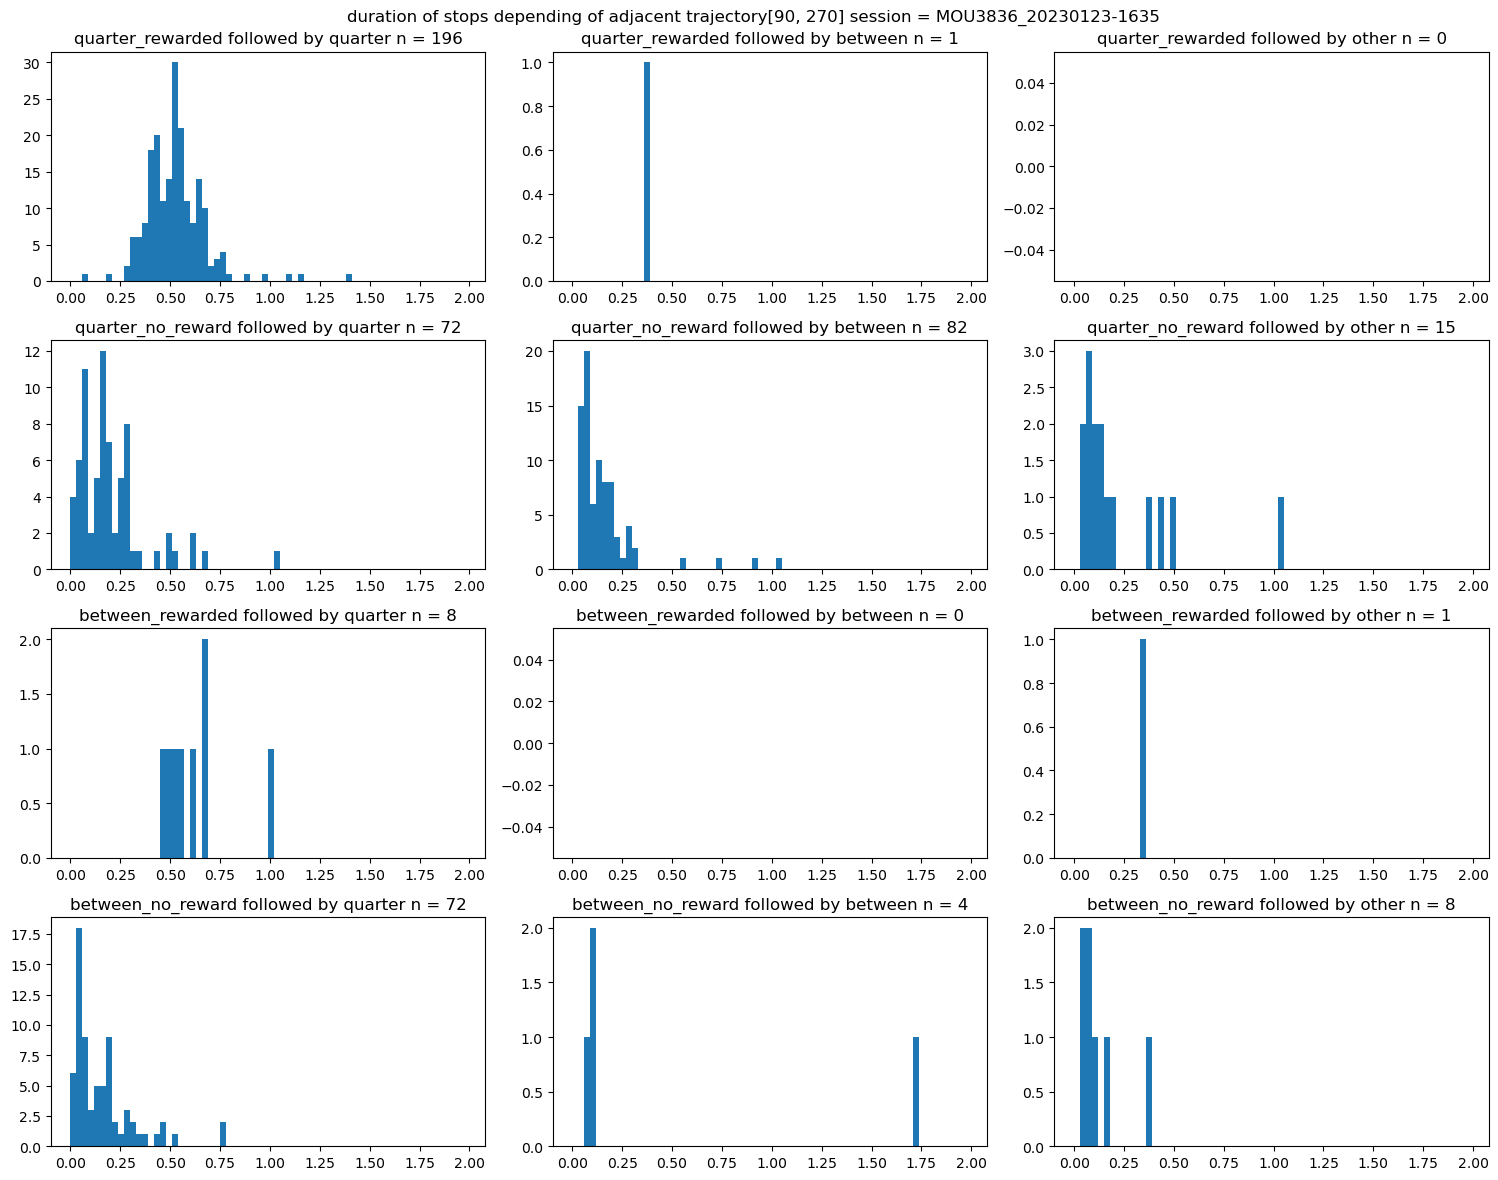

In [20]:
nb_column = 3 ; nb_line = 4 #define the number of column and line which are going to be plotted in the subplots
plt.figure(figsize= (nb_column * 5, nb_line * 3))#change the dimension of the figure accordingly
categories = ["quarter_rewarded", "quarter_no_reward","between_rewarded", "between_no_reward"]
followed_by = ["quarter", "between", 'other']
test = []

for a in range(nb_line * nb_column) :
    i = a % nb_column #remaining : number of the column in the line (-1)
    b = a // nb_column# division : number of the line (-1)

    plt.subplot(nb_line, nb_column, a + 1)
    variable = [time_average[u[1]] - time_average[u[0]]  for u in stops_type[categories[b]][followed_by[i]]]
    plt.hist(variable, bins = np.arange(0, 2, 0.03))
    test.append(variable)
    plt.title(categories[b] + " followed by " + followed_by[i] + " n = " + str(len(variable)))

plt.suptitle("duration of stops depending of adjacent trajectory"  + session_direction + " session = " + session)
plt.tight_layout()


print(stats.alexandergovern(test[0], test[3], test[9], test[6]))


number of turn asked for and done depending on the direction

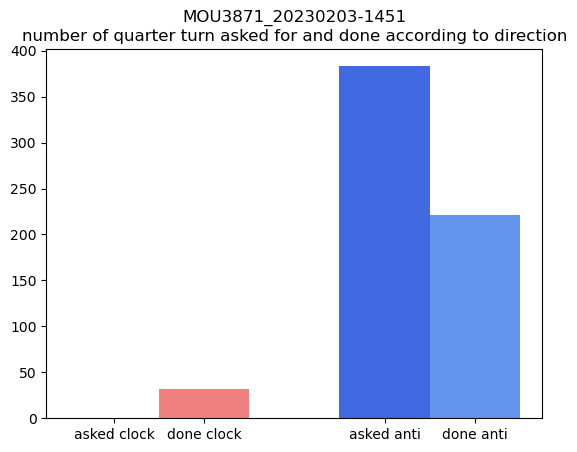

In [13]:
#utiliser la reccuperation des epochs pour le colored dot de l'html 
#s'en servir pour determiner le nombre de quart de tour demande dans les =! directions
#utiliser la mesure clockwise/counter de quart de tour pour determiner leur nombre

total_asked_clockwise = sum([a[1] for a in list_number_reward if list_quarter_turn[a[0]][2][1] == 'w' ])
total_aked_counter = sum([a[1] for a in list_number_reward if list_quarter_turn[a[0]][2][1] == 'k' ])

plt.bar([0,1, 3, 4], [total_asked_clockwise, len(clock_turn['total']), total_aked_counter, len(anti_clock_turn['total'])], color = ['indianred', 'lightcoral', 'royalblue', 'cornflowerblue'], width= 1)
plt.xticks(ticks = [0, 1, 3, 4], labels= ["asked clock", "done clock", "asked anti", "done anti"])
plt.title(session + "\nnumber of quarter turn asked for and done according to direction")
plt.show()

acceleration

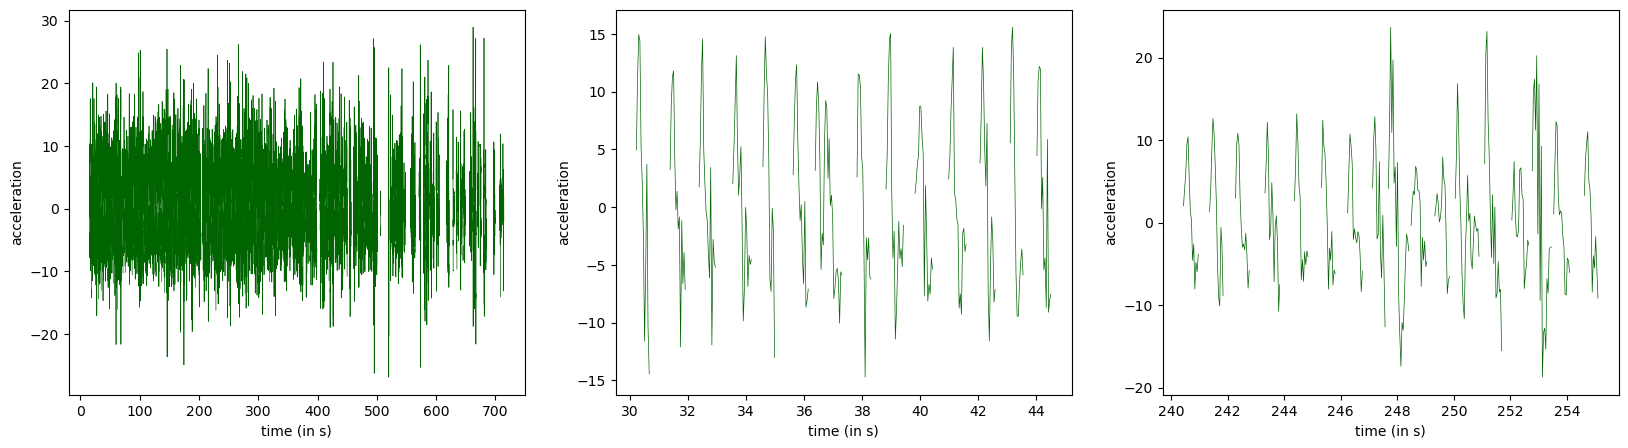

In [21]:
plt.figure( figsize = (20, 5))
for a in range(number_of_analysis):
    plt.subplot(1, number_of_analysis, a+1)
    smaller_epochs = get_epoch_small_analysis(epochs= list_epochs_angle, when_is_in_analysis= when_is_in_analysis[a])
    for i in range(len(smaller_epochs)) :
        plt.plot(time_average[smaller_epochs[i][0] - 1 : smaller_epochs[i][1]], acceleration[smaller_epochs[i][0] - 1 : smaller_epochs[i][1]], linewidth = 0.5, c = "darkgreen")
    plt.xlabel('time (in s)')
    plt.ylabel('acceleration')
plt.show()


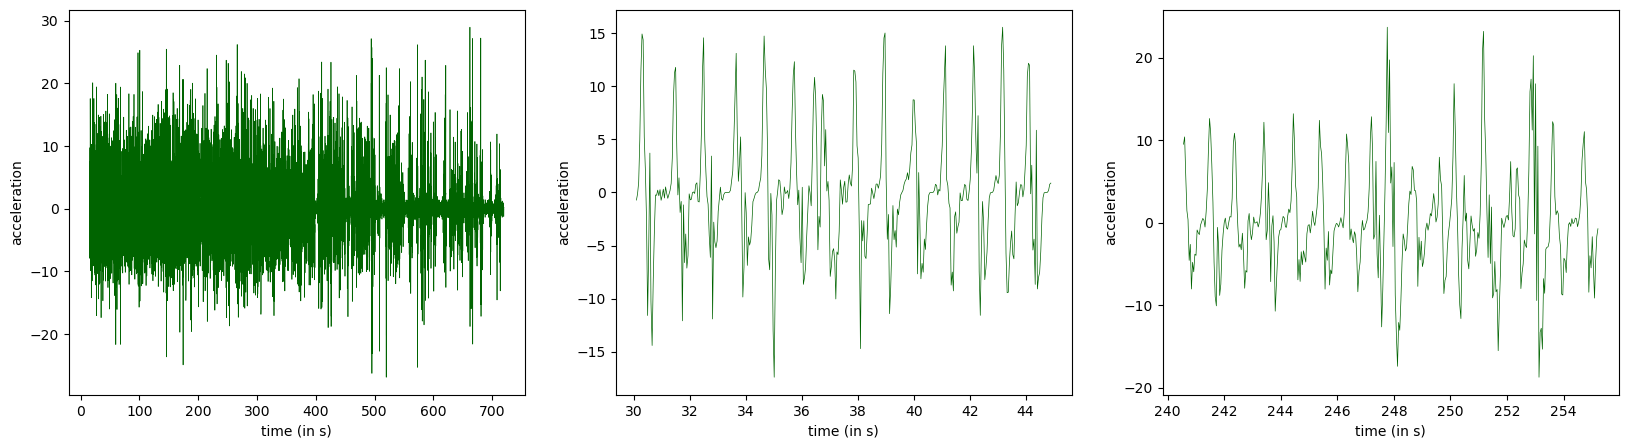

In [22]:
plt.figure( figsize = (20, 5))
for a in range(number_of_analysis):
    plt.subplot(1, number_of_analysis, a+1)
    plt.plot(time_average[when_is_in_analysis[a][0] + 2 : when_is_in_analysis[a][1]], acceleration[when_is_in_analysis[a][0] + 2 : when_is_in_analysis[a][1]], linewidth = 0.5, c = "darkgreen")
    plt.xlabel('time (in s)')
    plt.ylabel('acceleration')
plt.show()

show where the cut between epochs were made

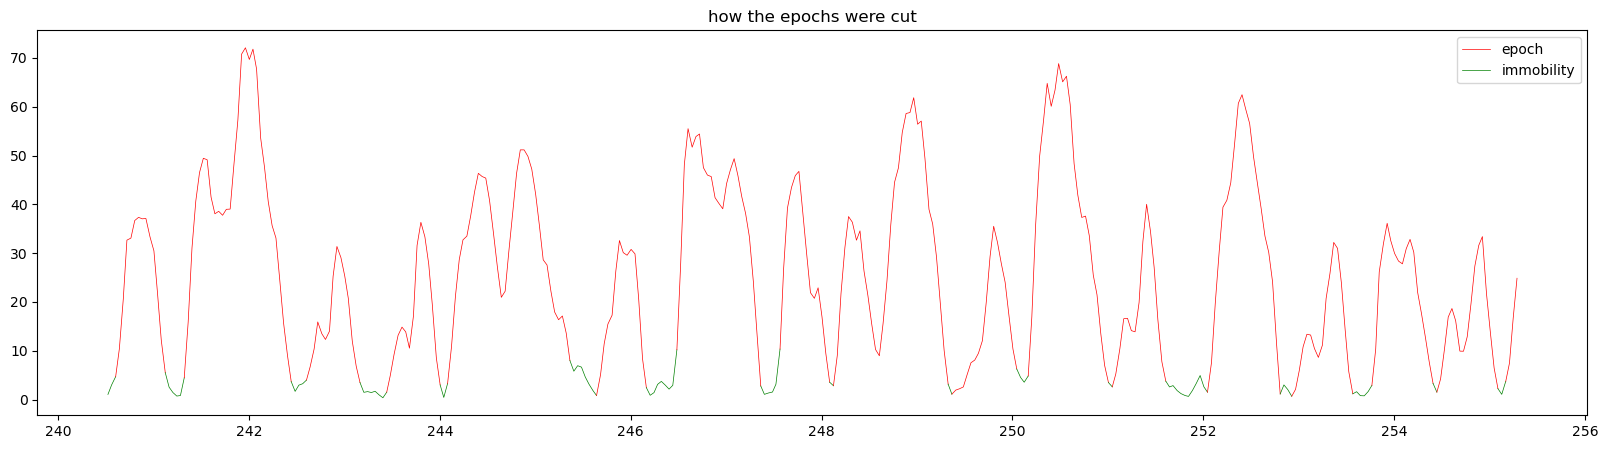

In [10]:
show_cut_epoch(speeds_gauss, time= time, epochs = list_epochs, when_is_in_analysis= when_is_in_analysis[2])

Test the correlation between time since the beginning of the session and the speed between object

BETWEEN OBJECTS: correlation of time and max speed
 rvalue : -0.13807254630653806 p-value : 0.18688635472143234standard error : 0.00857576230266211
BETWEEN OBJECTS: correlation of distance of the movement and max speed 
rvalue : 0.28672033025446286 p-value : 0.005329851210406637standard error : 11.20924048360371
Quarter Turns: correlation of time and max speed
rvalue : -0.12092012178468613 p-value : 0.020672022689161344standard error : 0.0028382455455269093


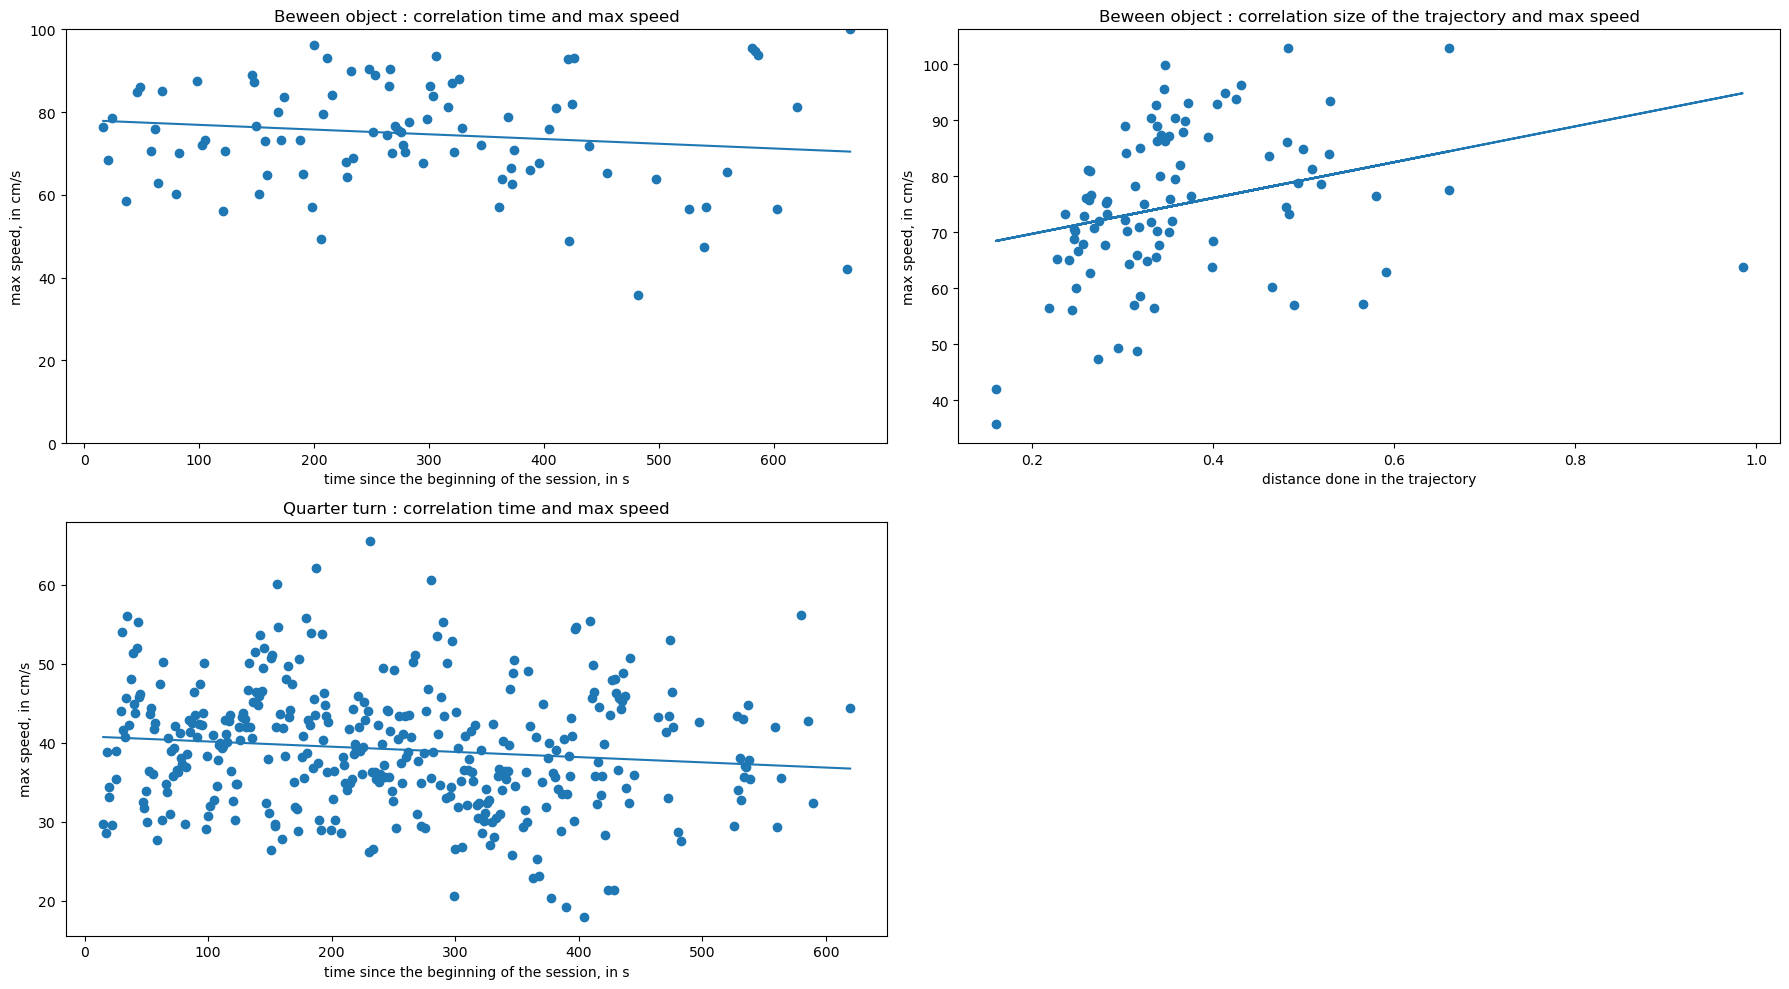

In [24]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)#plot the correlation of max speed in the between object trajectory and the time since the beginning of the session
y = [max(speeds_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]
x = [ time[u[0]] for u in list_epochs_angle if u[2][0] == "B"]
plt.scatter(x , y)
slope, intercept,  rvalue, pvalue, error = stats.linregress(x, y)
print("BETWEEN OBJECTS: correlation of time and max speed\n rvalue : " + str(rvalue) + " p-value : " + str(pvalue) + "standard error : " + str(error))
plt.plot(x, [ intercept +( a * slope) for a in x])
plt.title("Beween object : correlation time and max speed")
plt.xlabel("time since the beginning of the session, in s"); plt.ylabel("max speed, in cm/s")
plt.ylim(0, 100)


plt.subplot(2, 2, 2)#plot the correlation of max speed in the between object trajectory and the distance done in 
x = [ sum(distances_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]
slope, intercept,  rvalue, pvalue, error = stats.linregress(x, y)
print("BETWEEN OBJECTS: correlation of distance of the movement and max speed \nrvalue : " + str(rvalue) + " p-value : " + str(pvalue) + "standard error : " + str(error))
plt.scatter(x , y)
plt.plot(x, [ intercept +( a * slope) for a in x])
plt.title("Beween object : correlation size of the trajectory and max speed")
plt.xlabel("distance done in the trajectory"); plt.ylabel("max speed, in cm/s")


plt.subplot(2, 2, 3)#plot the correlation of max speed in the quarter turn trajectory and the time since the beginning of the session
y = [max(speeds_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "Q"]
x = [ time[u[0]] for u in list_epochs_angle if u[2][0] == "Q"]
plt.scatter(x , y)
slope, intercept,  rvalue, pvalue, error = stats.linregress(x, y)
plt.plot(x, [ intercept +( a * slope) for a in x])
print("Quarter Turns: correlation of time and max speed\nrvalue : " + str(rvalue) + " p-value : " + str(pvalue) + "standard error : " + str(error))
plt.title("Quarter turn : correlation time and max speed")
plt.xlabel("time since the beginning of the session, in s"); plt.ylabel("max speed, in cm/s")

plt.tight_layout()
plt.show()

graph du nombre de tours consecutifs en fonction du nombre de recompense max tire (part1)
graph du nombre d'extra tour en fonction du nombre de tour tire (part2)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fa92c9ae5b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fa92c9ae550>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fa92c9a4c40>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fa92c7a31c0>}

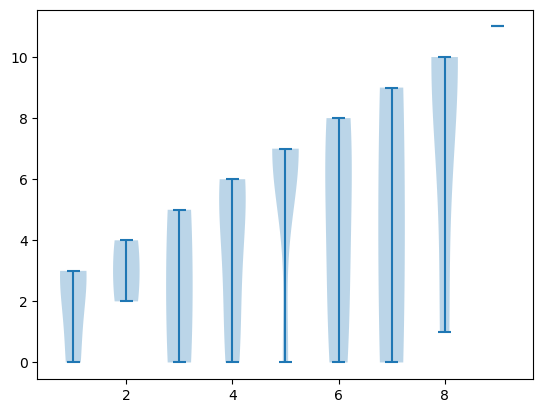

In [25]:
#iterate on dinfo. Look what is the last number of consecutive reward obtained on a given streak (take out the first - 1). If the max is 0, discard it, else store the number of turns
start = 0
while dinfo.loc[dinfo.index[start], 'Rewarded'] :
    start = start +1


current_object = dinfo.loc[dinfo.index[start], 'ongoingRewardedObject']
current_direction = dinfo.loc[dinfo.index[start], 'ongoingRewardedDirection']
current_max_reward = 0
consec_reward_start_object = -1 #-1 is used to signal the mouse is not currently in a serie

dict_number_turn_according_to_max_reward = {'4': [], '5' : [], '6': [], '7' : [], '8' : [], '9' : [], '10' : [], '11' : [], '12' : []}

for line in range(start, len(dinfo)):
    if dinfo.loc[dinfo.index[line], 'Rewarded'] :#if the turn was rewarded

        if consec_reward_start_object == -1 :#if this is the first reward of the mouse , initialize all the information for the serie
            consec_reward_start_object = dinfo.loc[dinfo.index[line], 'nberOfConsecRewards']#normally, it's 0
            current_object = dinfo.loc[dinfo.index[line], 'ongoingRewardedObject']
            current_direction = dinfo.loc[dinfo.index[line], 'ongoingRewardedDirection']
            current_max_reward = dinfo.loc[dinfo.index[line],'maxNberOfConsecRewards']
            limit_reward = current_max_reward + consec_reward_start_object #if the number of consecutive reward goes beyond it without any change, we have drawn a new trial with the exact same conditions

        else : #if this is not the first, check if the situation as changed
            if current_object != dinfo.loc[dinfo.index[line], 'ongoingRewardedObject'] or current_direction != dinfo.loc[dinfo.index[line], 'ongoingRewardedDirection'] or current_max_reward != dinfo.loc[dinfo.index[line],'maxNberOfConsecRewards'] or dinfo.loc[dinfo.index[line], 'nberOfConsecRewards'] > limit_reward :
                #if we enter here then we changed the serie without an error of the mouse
                dict_number_turn_according_to_max_reward[str(current_max_reward)].append(dinfo.loc[dinfo.index[line - 1], 'nberOfConsecRewards'] - consec_reward_start_object)

                consec_reward_start_object = dinfo.loc[dinfo.index[line], 'nberOfConsecRewards']
                current_object = dinfo.loc[dinfo.index[line], 'ongoingRewardedObject']
                current_direction = dinfo.loc[dinfo.index[line], 'ongoingRewardedDirection']
                current_max_reward = dinfo.loc[dinfo.index[line],'maxNberOfConsecRewards']
                limit_reward = current_max_reward + consec_reward_start_object #if the number of consecutive reward goes beyond it without any change, we have drawn a new trial with the exact same conditions
            #else : pass


    else :
        if consec_reward_start_object != -1 : #check if the mouse was in a serie
            #if it was in a serie
            dict_number_turn_according_to_max_reward[str(current_max_reward)].append(dinfo.loc[dinfo.index[line - 1], 'nberOfConsecRewards'] - consec_reward_start_object)

            consec_reward_start_object = -1 #signal that we are no longer in a serie. The current informations on where the animal is are no useful for now


plt.violinplot([dict_number_turn_according_to_max_reward[clef] for clef in dict_number_turn_according_to_max_reward.keys()])


individual correlation

PearsonRResult(statistic=-0.12085064816220453, pvalue=0.2485353685469546)


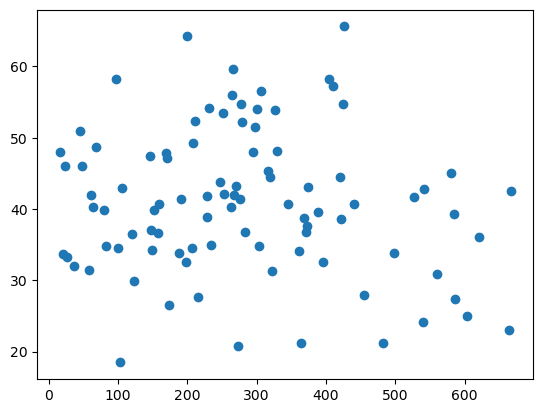

In [26]:
x = [median(speeds_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"] #the median seems to work better but is still not statistically significatif
y = [ time[u[0]] for u in list_epochs_angle if u[2][0] == "B"]
print(stats.pearsonr(y, x))
plt.scatter(y , x)

Test the correlation between distance done during the epoch and the speed between object

PearsonRResult(statistic=0.2867203302544628, pvalue=0.005329851210406665)


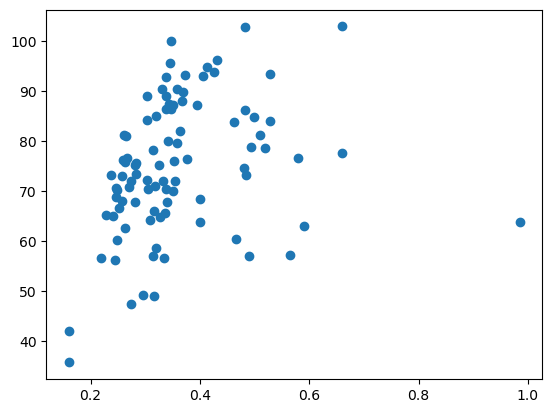

In [27]:
x = [max(speeds_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]#max seems to be the better predictor here, but not perfect
y = [ sum(distances_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]
print(stats.pearsonr(y, x))
plt.scatter(y , x)


PearsonRResult(statistic=0.22785849000226444, pvalue=0.02804535826944785)


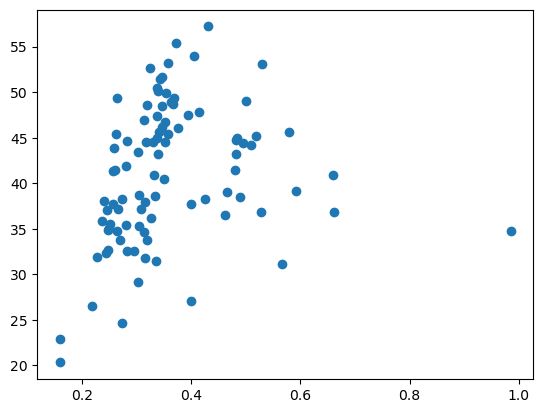

In [28]:
x = [np.mean(speeds_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]
y = [ sum(distances_gauss[u[0] : u[1] + 1]) for u in list_epochs_angle if u[2][0] == "B"]
print(stats.pearsonr(y, x))
plt.scatter(y , x)


<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>


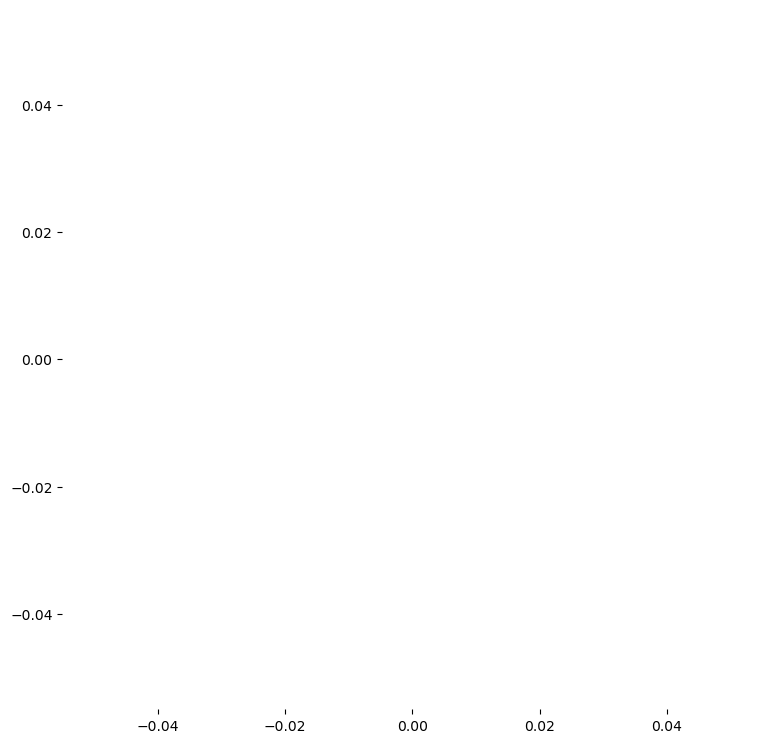

In [11]:
#tests en tout genre


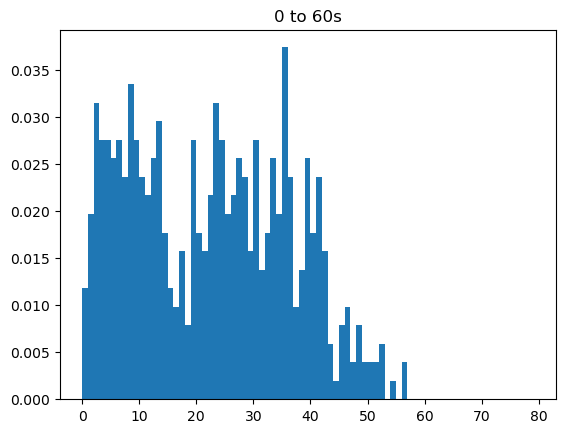

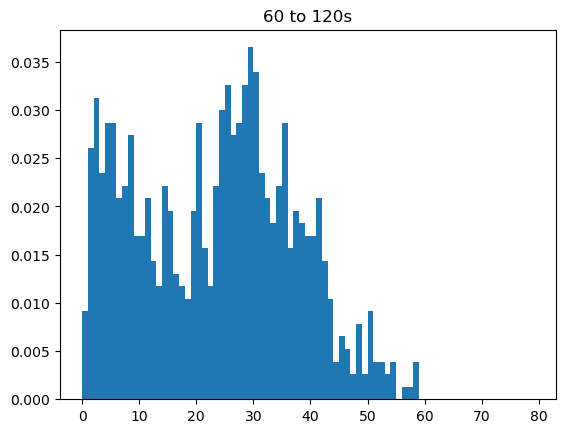

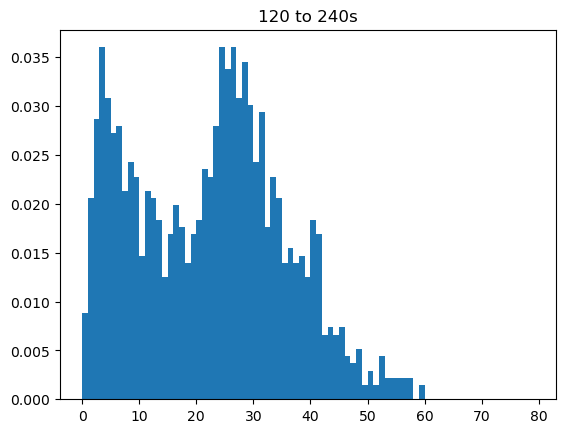

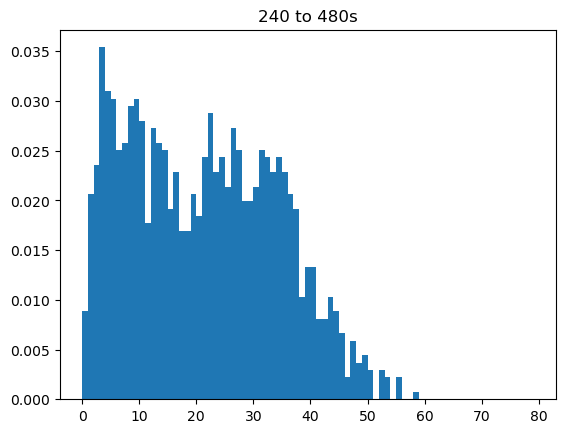

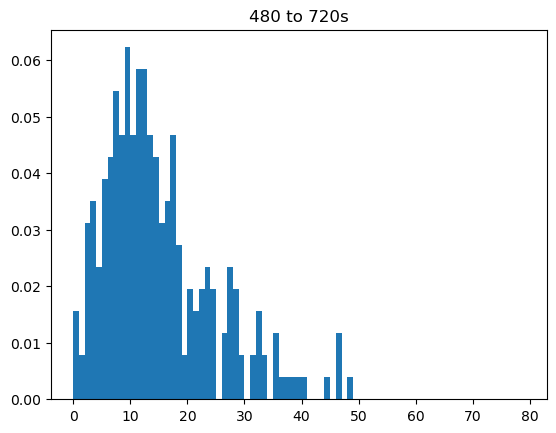

In [8]:
#tests en tout genre

for a in [[0, 60], [60, 120], [120, 240],[240, 480], [480, 720]] :
    speedy = [speeds_gauss[x] for e in list_quarter_turn for x in range(e[0], e[1] + 1) if time_average[e[1]]< a[1] and time_average[e[1]]>= a[0]]
    _ = plt.hist(speedy, bins = np.arange(0, 80, 1), density = True)
    plt.title(str(a[0]) + " to " + str(a[1]) + "s")
    plt.show()

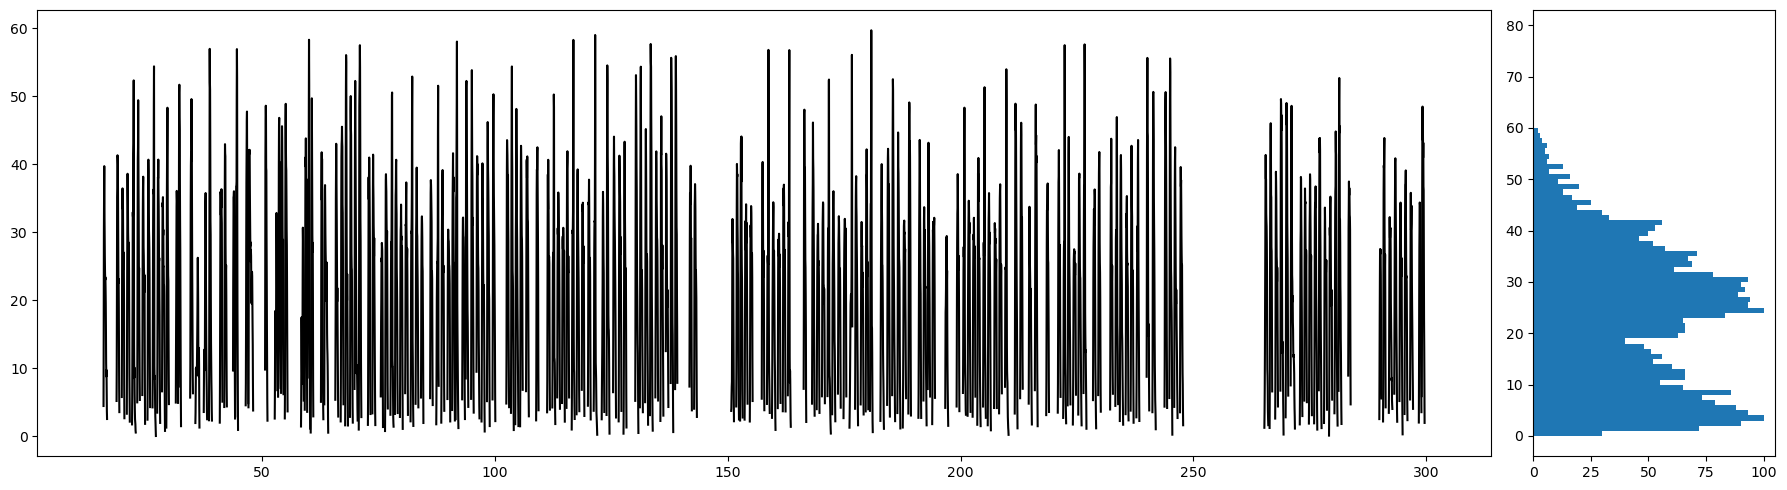

In [13]:
#tests en tout genre
speedy = [speeds_gauss[x] for e in list_quarter_turn for x in range(e[0], e[1] + 1) if time_average[e[1]]< 300]
fig, axes = plt.subplots(1, 2, figsize = (18, 5), gridspec_kw= {'width_ratios': [6, 1]})
for quarter in list_quarter_turn :
    if time_average[quarter[1]] < 300 :
        axes[0].plot(time_average[quarter[0] : quarter[1] + 1], speeds_gauss[quarter[0] : quarter[1] + 1], c= 'k')
n, bins, _ = axes[1].hist(speedy, bins = np.arange(0, 80, 1), orientation = 'horizontal')
plt.tight_layout()
plt.show()

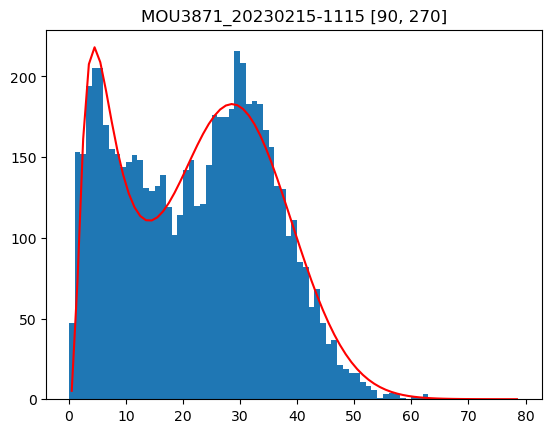

In [21]:
#try to fit two curve to explain the speed of the quarter turns
def gauss(x, A, x0, sigma): #mathemaical function
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def logNormal(x, mean_nu, variance_root, coefficient) :
    values = [(coefficient * np.exp(- (np.log(value) - mean_nu) ** 2)/ (2 *( variance_root ** 2))) / (value* variance_root * ((2 * np.pi) **  0.5)) for value in x]
    #x_by_variance = [value * variance_root for value in x]
    #np.exp(- (np.log(x - mean_nu) ** 2)/ (2 *( variance_root ** 2))) / (x* variance_root * ((2 * np.pi) **  0.5))
    return values

def doubleGausss(x, A1, A2, x01, x02, sigma1, sigma2):
    return gauss(x, A1, x01, sigma1) + gauss(x, A2, x02, sigma2)

def gaussAndLog(x, A, x0, sigma, mean_nu, variance_root, coefficient) : 
    return gauss(x, A=A, x0= x0, sigma= sigma) + logNormal(x = x, mean_nu= mean_nu, variance_root= variance_root, coefficient= coefficient)

from scipy.optimize import curve_fit

speedy = [speeds_gauss[x] for e in list_quarter_turn for x in range(e[0], e[1] + 1)]
n, bins, _ = plt.hist(speedy, bins = np.arange(0, 80, 1))
new_bins = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

#, bounds= (0, [0.1, 0.1, 100, 100, 60, 60, 100, 100])
#popt, pcov = curve_fit(f = doubleGausss, xdata = new_bins, ydata = n, p0=[ 100, 90, 7, 27, 1, 1])#popt contain the obtained values for everyone of the variables in the same order
popt, pcov = curve_fit(f = gaussAndLog, xdata = new_bins, ydata = n, p0=[ 200, 27, 1, 1.6, 0.5, 200], bounds= (0, np.inf))
#plt.plot(new_bins, doubleGausss(x = new_bins, A1= popt[0], A2= popt[1], x01= popt[2], x02= popt[3], sigma1= popt[4], sigma2= popt[5]), c = 'r')
plt.plot(new_bins, gaussAndLog(x = new_bins, A= popt[0], x0= popt[1], sigma=popt[2], mean_nu=popt[3], variance_root= popt[4], coefficient= popt[5]), c = 'r')
plt.title(session + " " + session_direction)
plt.show()


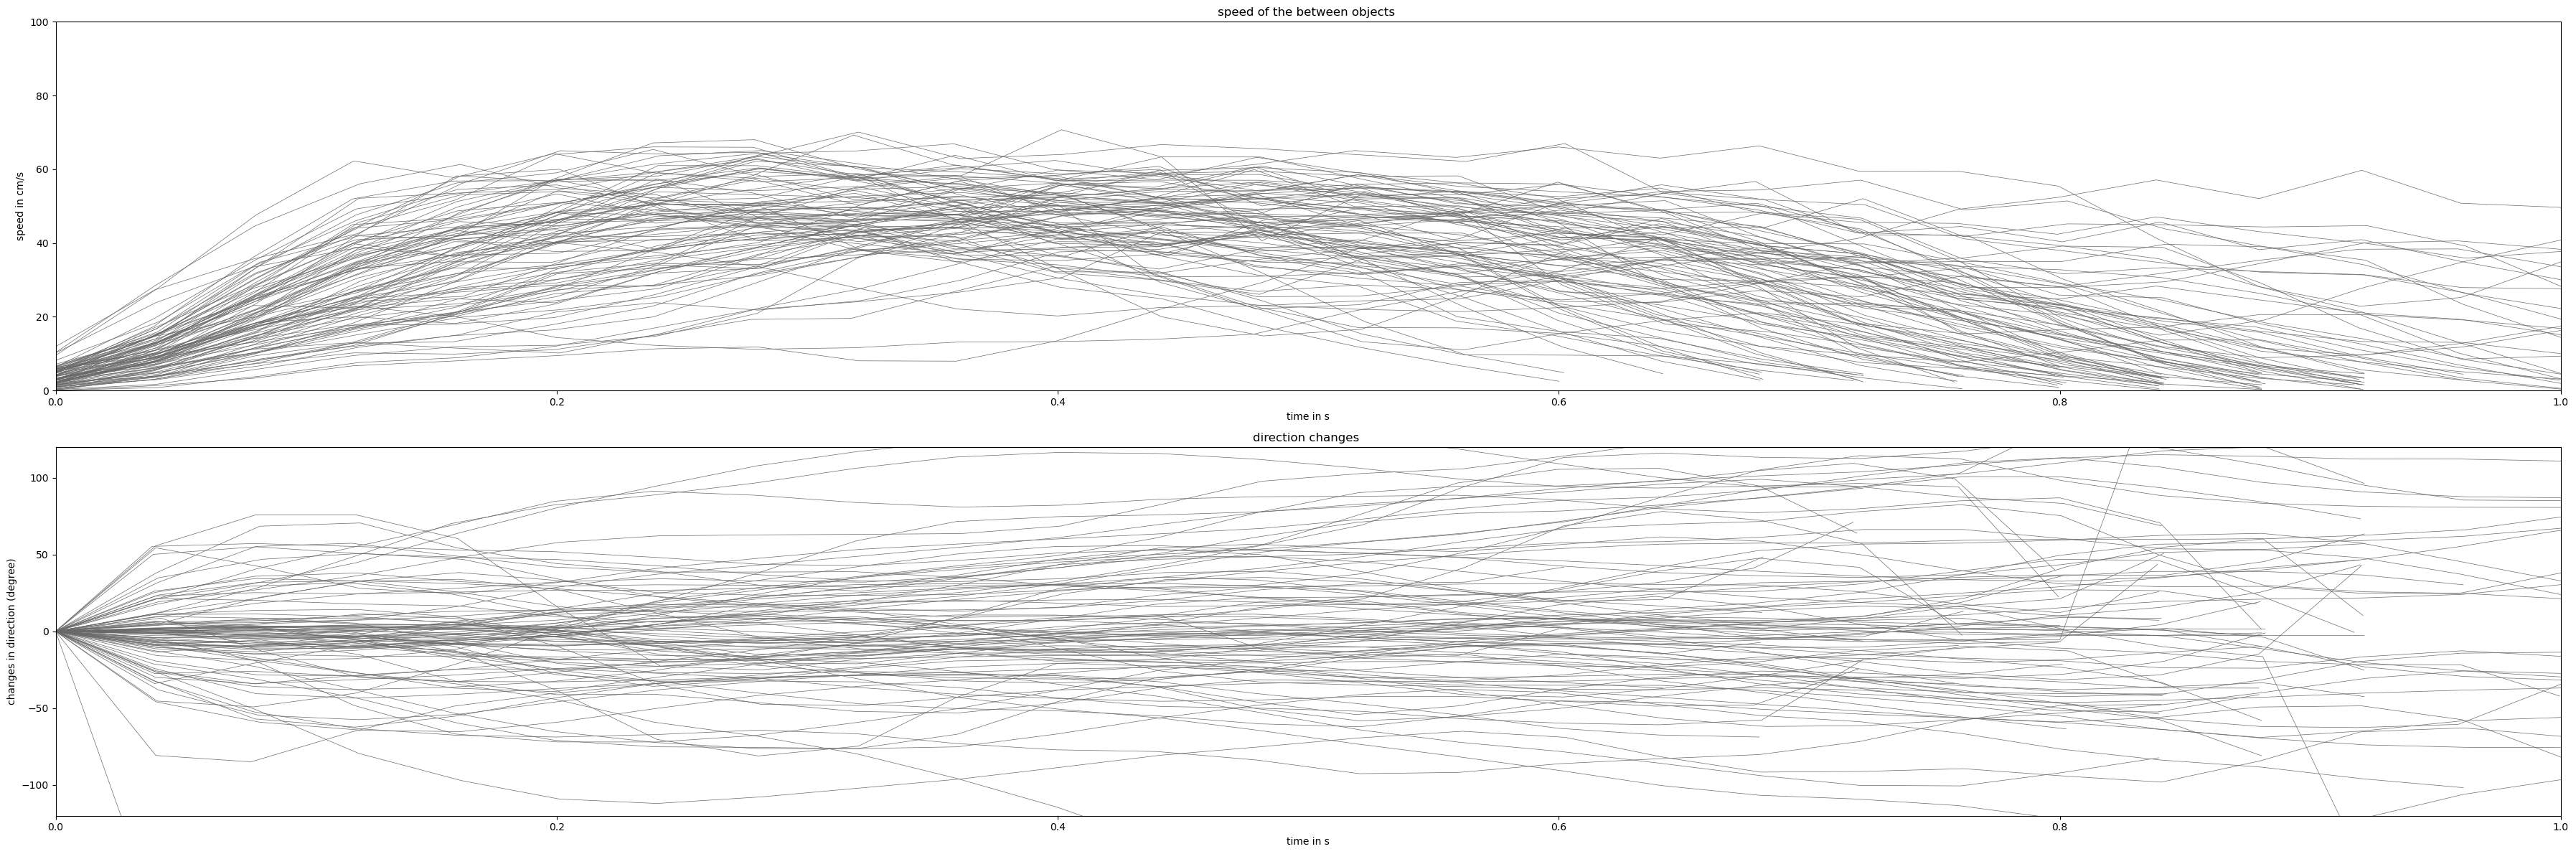

In [25]:
#profiles of between objects
plt.figure(figsize=(36, 12))
plt.subplot(2, 1, 1)#plot the indidual speed profile of every quarter turn
for u in list_between_object :
    plt.plot(timeofframes[u[0] : u[1] + 1]  - timeofframes[u[0]], speeds_gauss[u[0] : u[1] + 1], linewidth = 0.5, c= "dimgray")
plt.xlim(0, 1); plt.ylim(0, 100)
#xmed, ymed = compute_median_trajectory([speeds_gauss[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]], [timeofframes[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]])
#plt.plot(xmed, ymed, c= 'crimson')
plt.title("speed of the between objects " )
plt.ylabel("speed in cm/s"); plt.xlabel("time in s")
    
    ###########
plt.subplot(2, 1, 2) #plot the individual profile of the direction of every quarter turn
list_temp_orientation = []
for u in list_between_object:
    temp_orientation = angles[u[0] : u[1] + 1] - angles[u[0]]
    for i in range(1, len(temp_orientation)):
        if (temp_orientation[i] - temp_orientation[i - 1]) < -200 :#if the orientation passed the threshold and moved to the other side, move it to stay within the continuity
            temp_orientation[ i ] += 360
        elif (temp_orientation[i] - temp_orientation[i - 1]) > 200 :
            temp_orientation[i] -= 360
        #if temp_orientation[i] <0 : temp_orientation[i] = - temp_orientation[i]
    list_temp_orientation.append(temp_orientation)
    plt.plot(time_average[u[0]: u[1] + 1] - time_average[u[0]], temp_orientation, linewidth = 0.5, c= "dimgray")
plt.ylim(-120, 120); plt.xlim(0, 1)
plt.ylabel("changes in direction (degree)"); plt.xlabel("time in s")
#xmed, ymed = compute_median_trajectory(list_temp_orientation, [time_average[u[0] : u[1] + 1] for u in [clock_turn["total"], anti_clock_turn["total"]][a]])
#plt.plot(xmed, ymed, c= 'crimson')
plt.title("direction changes ")
plt.tight_layout()
plt.show()

(-0.5, 99.5, 99.5, -0.5)

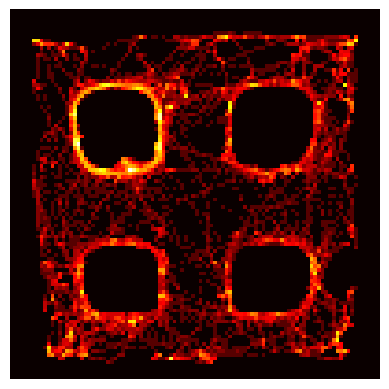

In [18]:
maps_union = np.zeros((100, 100))


for u in range(len(xgauss)) :
    maps_union[  int((Resolution[1] - ygauss[u]) *100 /Resolution[1]), int(xgauss[u] * 100 /Resolution[0]) ] +=1 #for each position of the mouse add  one to the corresponding entry in the grid

#maps_union[0,0] = np.max(maps_union)#set a maximum for all maps
maps_union[1,0] = 0 #set the adjacent pixel as a minimum for all maps
maps_union = np.log(maps_union + 1)#take the log of the graph to keep them readable



plt.imshow(maps_union, cmap='hot', interpolation='nearest')
#plt.scatter([int(waterports[i][1] * 100 / Resolution[0]) for i in waterports],[int(waterports[i][0] * 100 / Resolution[0]) for i in waterports], c= "blue")
plt.axis('off')


(0.0, 1.0)

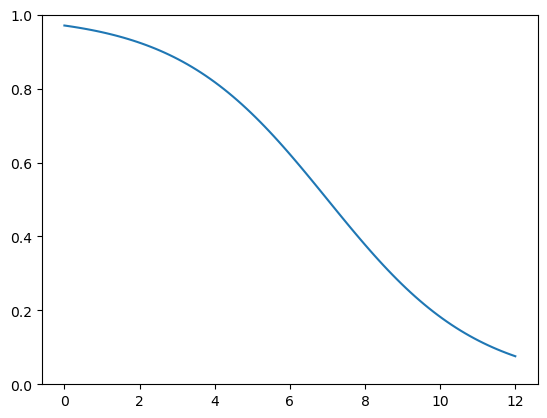

In [4]:
#tests en tout genre
def sigmoid(x, ghrowthRate, v, Q) :
    return 1 - 1/ ((1 + Q * np.exp(-ghrowthRate * (x - 7))) ** 1/v)

sigmoid(0, 0.5, 1, 1)
x = np.linspace(0, 12, 100)
y = sigmoid(x, 0.5, 1, 1)
plt.plot(x, y)
plt.ylim(0, 1)

In [2]:
#tests en tout genre
test = [1,2, 3, 4, 5]
t = [value*time for value in test if value != 3 ]
t

[1, 2, 4, 5]

test unitaire necessaire pour les calculs de distance, de vitesse, de decoupage en epochs, le calcul des angles (? c'est surtout une librairie qui s'en charge et les premiers tests semblaient bon) et de la vitesse angulaire

In [31]:
#test unitaire pour le calcul de distance
xtest = [1, 2, 2, 1, 1,     11, 11, 1, 1,   2, 3, 2, 1,    11, 21, 11, 1, 5,     5.1, 5.1, 5.1, 5,  5.1, 5.2, 5.1, 5.0,     6.1, 6.1, 5.0, 5.0,     8.3, 9.8, 8.3, 5]#both coordinate are strictly positive
ytest = [1, 1, 2, 2, 1,     1, 11, 11, 1,   2, 1, 2, 1,    11, 1, 11, 1, 5,      5, 5.1, 5, 5,      5.1, 5.0, 5.1, 5.0,     5.0, 6.1, 6.1, 5.0,     8.3, 6.8, 8.3, 5] 

excpected_distance = [1, 1, 1, 1,   10, 10, 10, 10,     2**0.5, 2**0.5, 2**0.5, 2**0.5,     200**0.5, 200**0.5, 200**0.5, 200**0.5, 32**0.5,    0.1, 0.1, 0.1, 0.1,     0.02**0.5, 0.02**0.5, 0.02**0.5, 0.02**0.5,     1.1, 1.1, 1.1, 1.1,     (2 * 3.3**2) **0.5, (2 * 1.5**2) **0.5, (2 * 1.5**2) **0.5, (2 * 3.3**2) **0.5]

test_distances=np.array([((((xtest[i]-xtest[i-1])**2)+((ytest[i]-ytest[i-1])**2))**0.5) for i in range(1,len(ytest))]) 
#distances = distances *(0.84/Resolution[0]) #convert distance to m with apparatus length =84cm
result = [isclose(test_distances[i], excpected_distance[i]) for i in range(len(excpected_distance))]
print(result)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [32]:
#test unitaire pour le calcul de vitesse
test_distances = [0, 0, 0, 0,        1, 2, 11, 98,   3, 6, 33, 99,     1, 2, 11, 97,      0.1, 0.37, 0.54, 0.70, 0.99,     0.1, 0.37, 0.54, 0.70, 0.99,]#distance in m appartient a D+
test_time =   [0, 1, 1.23, 1.52, 2,   3, 4, 5, 6,     9, 12, 15, 18,    21, 24, 27, 30,    31, 32, 33, 34, 35,              35.1, 35.2, 35.3, 35.4, 35.5,]#time in s, strictly positive progression. Must be 1 indice longer than distance, appartiens a D+


expected_speed = [0, 0, 0, 0, 0,          100, 200, 1100, 9800,    100, 200, 1100, 3300,     100/3, 200/3, 1100/3, 9700/3,   10, 37, 54, 70, 99,     100, 370, 540, 700, 990,]

test_timeBetween=np.diff(test_time)#get the gap between the frames
#compute the speed in pixels/s, using both the distance for the original data and the smoothen one
test_speed =np.divide(test_distances,test_timeBetween)
#get the speed in cm/s and add a speed of 0 at the beginning to keep the same data size
test_speed = np.insert(test_speed, 0, 0) * 100

result = [isclose(test_speed[i], expected_speed[i]) for i in range(len(expected_speed))]
print(result)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [33]:
test_speed

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  100.        ,  200.        , 1100.        ,
       9800.        ,  100.        ,  200.        , 1100.        ,
       3300.        ,   33.33333333,   66.66666667,  366.66666667,
       3233.33333333,   10.        ,   37.        ,   54.        ,
         70.        ,   99.        ,  100.        ,  370.        ,
        540.        ,  700.        ,  990.        ])